<a href="https://colab.research.google.com/github/marcinwolter/MedicalPictures/blob/master/figure_jpeg_cnn_visual_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Code generating geometrical figures and calculating SSIM & MSE {and performing pattern recognition using Deep NN}**

*July 2020, Marcin Wolter*

In [130]:
'''Trains a simple convnet on the generated set of figures (circle, triangle, square)
'''
from __future__ import print_function

# install keras
!pip install -U keras
#install KERAS if not there
!pip install keras_sequential_ascii

import matplotlib.pyplot as plt
import matplotlib.pylab as pyl
import numpy as np

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation
from keras import backend as K
from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras.utils import plot_model
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import metrics

from PIL import Image, ImageDraw

import time
import math



Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)


# **Mount google disk**

In [131]:
# Mounting google disk commented out
#from google.colab import drive
#drive.mount('/content/drive')

Prevent Google Colab from disconnecting

In [132]:
from IPython.display import display, HTML
js = ('<script>function ConnectButton(){ '
           'console.log("Connect pushed"); '
           'document.querySelector("#connect").click()} '
           'setInterval(ConnectButton,3000);</script>')
display(HTML(js))

# **Setup the parameters**

In [133]:
# DNN parameters
batch_size = 128
# number of classes
num_classes = 2
# Set number of training epochs to 2 to speed up training (meaningless training results)
epochs = 2  #256 #12

np.random.seed(2348)

#batch_size_gen = 60000
#batch_size_val = 10000
batch_size_gen = 600
batch_size_val = 100

# input image dimensions
img_rows, img_cols = 32, 32
img_shape = (img_rows, img_cols)


#probability of noise and its max. brithness 
prob_noise = 1.0
ampl_noise = 0.3


# figure min and max brithness
fig_min_gray=0.4
fig_max_gray=0.9

#figure sizes
# circle radius
rmin = 0.06
rmax = 0.15
# triangle/rectangle size
dmin = 0.10
dmax = 0.30
# colon / line dot radius in pixels
rpix_min = 0.5
rpix_max = 3

# distortion type
###distortion = "blur"
distortion = "jpeg"
# jpeg_format: jpeg / JPEG2000   - WARNING:  JPEG 2000 does not work on Kaggle!!!!
#jpeg_format = "jpeg"
jpeg_format = 'JPEG2000'
#jpeg_format="jpx"
# distortion - bluring sigma
sigma = (1.8,1.8)
#jpeg compression
jpeg_compression_list = [97, 80, 32, 15, 7, 3]   
jpeg2000_compression_list = [[1],[2],[4],[8],[16],[32]] 


# extrapolate True/False
extrapolate = True
# list of extrapolation factors
extrapolation_list = [0.50, 1., 2.]
###extrapolation_list = [1.]

# Generated 32x32 small image is pasted on a big image, which is a subject of
# graphical operations (jpeg compression, scaling etc). Then it is cropped out
# of it. The big image size is defined here:
bigIm_shape = (512, 512)
smallIm_X = 240
smallIm_Y = 240
# number of images to test the size
n_big = 500

#resample method BICUBIC/NEAREST/BILINEAR
method = Image.BICUBIC
#method = Image.BILINEAR
#method = Image.NEAREST

#Remove the saved DNN
! rm best_model.h5
# make directory to store images
! mkdir images
! rm images/*

mkdir: cannot create directory ‘images’: File exists


# **Generate noise**

In [134]:
def gen_noise(batch_size_gen=batch_size_gen, img_shape=img_shape, prob_noise=prob_noise):

        batch_events = np.zeros((batch_size_gen, 1, img_shape[0], img_shape[1]))
        for n in range(batch_size_gen):

            for i in range(img_shape[0]):
               for j in range(img_shape[1]):
                 if np.random.random()<prob_noise:
                     batch_events[n,0,i,j]= min(1.,max(0.,ampl_noise*np.random.randn()))


        yield batch_events


#  Generate geometrical figures - circle, triangle, square, colon, line

In [135]:

### generate geometrical figures

def generate_circle(r, x0, y0, img_shape):
    """
    Generate a single circle.
    Parameters:
        r: radius
        x0,y0: position of the circle center
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('L', img_shape) #create new image, 10x10 pixels, 1 bit per pixel
    draw = ImageDraw.Draw(image)
    draw.ellipse((x0-r, y0-r, x0+r, y0+r), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image)/255
    
    #print(x)
    return x

In [136]:
def generate_square(d, x0, y0, angle, img_shape):
    """
    Generate a square.
    Parameters:
        d: size
        x0,y0: position of the square center
        angle: rotation angle
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('L', img_shape) #create new image, 32x32 pixels, 8 bit per pixel
    draw = ImageDraw.Draw(image)
    draw.rectangle((x0-d/2, y0-d/2, x0+d/2, y0+d/2), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    image = image.rotate(angle)
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image)/255

      
    #print(x)
    return x




In [137]:
def generate_triangle(d, x0, y0, angle, img_shape):
    """
    Generate a triangle.
    Parameters:
        d: size 
        x0,y0: position of the triangle center
        angle: rotation angle
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('L', img_shape) #create new image, 32x32 pixels, 8 bit per pixel grayscale
    draw = ImageDraw.Draw(image)
    dd = d/math.sqrt(3)
    draw.polygon(((x0-d/2, y0-dd/2), (x0+d/2, y0-dd/2), (x0,y0+dd)), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    image = image.rotate(angle)
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image)/255.
    
    #print(x)
    return x



In [138]:
def generate_line(r, x0, y0, angle, img_shape):
    """
    Generate a line.
    Parameters:
        r: width, length = 5*r
        x0,y0: position of the line center
        angle: rotation angle
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('L', img_shape) #create new image, 32x32 pixels, 8 bit per pixel
    draw = ImageDraw.Draw(image)
    draw.rectangle((x0-2.5*r, y0-r, x0+2.5*r, y0+r), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    image = image.rotate(angle)
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image)/255

      
    #print(x)
    return x



In [139]:
def generate_colon(r, x0, y0, angle, img_shape):
    """
    Generate a colon.
    Parameters:
        r: dot radius
        x0,y0: position of the colon center
        angle: rotation angle
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('L', img_shape) #create new image, 32x32 pixels, 8 bit per pixel
    draw = ImageDraw.Draw(image)
    draw.ellipse((x0-1.5*r-r, y0-r, x0-1.5*r+r, y0+r), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    draw.ellipse((x0+1.5*r-r, y0-r, x0+1.5*r+r, y0+r), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    image = image.rotate(angle)
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image)/255

      
    #print(x)
    return x



In [140]:


# generate a random number
def rand_interval(a = 0., b = 1.):
   rnd = a + (b-a)*np.random.random()
   return rnd


# **Random figure generator**

In [141]:
# Generator for random figures
# Each image contains exactly one object (circle, triangle, square)
def gen_n_figures(batch_size_gen=batch_size_gen, img_shape=img_shape):

        batch_events  = np.zeros((batch_size_gen, 1, img_shape[0], img_shape[1]))
        batch_targets =-np.ones((batch_size_gen, 1, 1 ))

        for n in range(batch_size_gen):
            
            k = np.random.randint(0,num_classes)

            
            rpix = rand_interval(rpix_min,rpix_max)
            r = rand_interval(img_cols*rmin, img_cols*rmax)
            d = rand_interval(img_cols*dmin, img_cols*dmax) 
            l = rand_interval(img_cols*dmin, img_cols*dmax)
            x0 = rand_interval(0.33*img_cols, 0.66*img_cols)       
            y0 = rand_interval(0.33*img_rows, 0.66*img_rows)     
            alpha = 360.*np.random.random()  

            if k == 0:
               batch_events[n,0] = generate_colon(rpix, x0, y0, alpha, img_shape)
            elif k == 1:
               batch_events[n,0] = generate_line(rpix, x0, y0, alpha, img_shape)  
            elif k == 2:                
               batch_events[n,0] = generate_circle(r, x0, y0, img_shape)
            elif k == 3:
               batch_events[n,0] = generate_square(d, x0, y0, alpha, img_shape)
            elif k == 4:
               batch_events[n,0] = generate_triangle(l, x0, y0, alpha, img_shape)                             
            else:
               print("Wrong figure id!!!")
            batch_targets[n,0] = k
            


        yield batch_events, batch_targets



# **Distort an image** 
Distortion might be either bluring or a conversion to jpeg and back.

In [142]:
# Distort images
from scipy import ndimage
#PILlow package
from PIL import Image
from io import BytesIO
import scipy.misc

from skimage.metrics import mean_squared_error, structural_similarity, normalized_root_mse
import itertools
 

# Program to print matrix in Zig-zag pattern 
def zigZag(rows, columns, matrix, nElements):
  
  solution=[[] for i in range(rows+columns-1)] 
  
  for i in range(rows): 
    for j in range(columns): 
        sum0=i+j 
        if(sum0%2 ==0): 
  
            #add at beginning 
            solution[sum0].insert(0,matrix[i][j])            
        else: 
  
            #add at end of the list 
            solution[sum0].append(matrix[i][j]) 

  solution = list(itertools.chain.from_iterable(solution))
  #print("solution ",solution)
  del solution[:(len(solution)-nElements)]
  #print("truncated solution ",solution)

  return sum(solution)



def calc_ssim_mse(images, distorted_images):
# Calculate SSIM & MSE using https://scikit-image.org/docs/dev/genindex.html  

   mse = 0  # mean_squared_error
   nrmse = 0 # normalized_root_mse
   sim = 0   # structural_similarity
   qual_ind = 0 # quality index

   for n in range(len(images)): 
      im_array = np.asarray(images[n]).reshape(img_shape)
      imtest_array = np.asarray(distorted_images[n]).reshape(img_shape)
      
      #print("im shape ",im_array.shape)
      mse += mean_squared_error(im_array, imtest_array)
      nrmse += normalized_root_mse(im_array, imtest_array, normalization='euclidean')
      sim +=  structural_similarity(im_array, imtest_array, win_size=7, full=False)

      ft_im_array = np.square(abs(np.fft.fft2(im_array))) #mag sq of ft coeff
      ft_imtest_array = np.square(abs(np.fft.fft2(imtest_array)))

      nElements = 50
      zg_ft_im_array = zigZag(32, 32, ft_im_array, nElements)
      zg_ft_imtest_array = zigZag(32, 32, ft_imtest_array, nElements)

      qual_ind += structural_similarity(im_array, imtest_array, win_size=7, full=False) * zg_ft_imtest_array/zg_ft_im_array

   return mse/len(images), nrmse/len(images), sim/len(images), qual_ind/len(images)
 


def distort_n_figures(images, jpeg_compression, distortion=distortion, img_shape=img_shape, sigma = sigma):
  
  if (distortion == "blur"):
    images_distorted = np.zeros((len(images), 1, img_shape[0], img_shape[1]))
    for n in range(len(images)):
     
    
      images_distorted[n,0] = ndimage.gaussian_filter(255.*images[n,0], sigma=sigma)/255.
#      images_distorted[n,0] = images[n,0]

    mse, nrmse, ssim, qual_index = calc_ssim_mse(images, images_distorted)
    return -1, mse, nrmse, ssim, qual_index, images_distorted

  elif (distortion == "jpeg"):
    images_distorted = np.zeros((len(images), 1, img_shape[0], img_shape[1]))
    # create a BIG image just with noise
    array_big = next(gen_noise(1, bigIm_shape ))
    image_file_size = 0

    #n_big = len(images)

    for n in range(len(images)):
    #for n in range(5):  
        # convert to jpeg and than back
        if  (n+1)%10000==0:
           print("Distorting image ",n)

        buffer = BytesIO()
        auxIm = Image.fromarray((255.*images[n,0]).astype(np.uint8))

        
        #  might be removed temporarily not to make big pictures
        if n < n_big:
           #print("array_big.shape ",array_big[0,0].shape)
           bigIm = Image.fromarray((255.*array_big[0,0]).astype(np.uint8))
           #print("bigIm.size ",bigIm.size)
           #print("auxIm.size ",auxIm.size)
           #paste auxIm into the middle of bigIm
           bigIm.paste(auxIm,(smallIm_X,smallIm_Y))
           auxIm = bigIm
        #print("auxIm.size from bigIm ",auxIm.size)
        

        if jpeg_format == 'jpeg':
           auxIm.save(buffer, format=jpeg_format, quality=jpeg_compression)
           if n < n_big:
              auxIm.save("images/image_extr_"+str(extrapolation_factor)+"_jpg_"+str(jpeg_compression)+"_"+str(n)+".jpg", format=jpeg_format, quality=jpeg_compression)
        elif jpeg_format == 'JPEG2000':
           auxIm.save(buffer, format=jpeg_format, quality_mode='rates', quality_layers=jpeg_compression, irreversible=True) 
           if n < n_big: 
              auxIm.save("images/image_extr_"+str(extrapolation_factor)+"_jpg2000_"+str(jpeg_compression)+"_"+str(n)+".jp2", format=jpeg_format, quality_mode='rates', quality_layers=jpeg_compression, irreversible=True)
        else:
           print("Unknown format %s" % jpeg_format)    

        if n < n_big:
           image_file_size = image_file_size + buffer.tell()

  
        buffer.seek(0)
        auxIm = Image.open(buffer)

        # resize image and then resize back to the original size using BICUBIC/NEAREST/BILINEAR
        if (extrapolation_factor != 1.):
           width, height = auxIm.size
           auxIm = auxIm.resize((int(extrapolation_factor*width),int(extrapolation_factor*height)),resample=method)
           #print("image size ",auxIm.size)
           auxIm = auxIm.resize((width,height),resample=method)
        
        # crop original image from the big image
        if n < n_big:
           auxIm = auxIm.crop((smallIm_X,smallIm_Y,smallIm_X+img_cols,smallIm_Y+img_rows))
        #print("Final image size ",auxIm.size)

        # add image to the array of distorted images
        images_distorted[n,0] = np.array(auxIm) / 255. 
        #print(images_distorted[n,0])
 
    average_size = image_file_size/n_big
    
    mse, nrmse, ssim, qual_index = calc_ssim_mse(images, images_distorted)
    return average_size, mse, nrmse, ssim, qual_index, images_distorted

  else:
    return -1, -1, -1, -1, -1, images  

## **Plot some images**

In [143]:
def plot_images(plot_size=6):

  class_names = ['colon','line','circle','square','triangle']

  offset = max(0, min(batch_size_gen-plot_size*plot_size, np.random.randint(0,batch_size_gen/2)))
  plt.subplots_adjust(left=0.02, bottom=0.02, right=0.98, top=0.90, wspace=0.20, hspace=0.40)
  for n in range(min(plot_size*plot_size,len(xx_train))):
    ax = plt.subplot(plot_size, plot_size, n+1)
    ax.imshow(xx_train[n+offset,0], cmap='gray', vmin=0, vmax=1)
    ax.set_title(class_names[int(yy_train[n+offset,0])])
    ax.axis('off')

  plt.show()
  #plt.savefig('event.png')
  #plt.clf()


#plotting results of classification
def plot_results(plot_size=6):
  
  class_names = ['colon','line','circle','square','triangle']
  YY_pred = saved_model.predict(xx_val, verbose=2)
  
  offset = max(0, min(len(YY_pred)-plot_size*plot_size, np.random.randint(0,len(YY_pred)/2)))

  plt.subplots_adjust(left=0.02, bottom=0.02, right=0.98, top=0.90, wspace=0.20, hspace=0.40)
  for i in range(int(min(plot_size/2,len(YY_pred)/plot_size))):
    for n in range(int(min(plot_size,len(YY_pred)))):
      ax = plt.subplot(plot_size,plot_size,plot_size*2*i+n+1 )
      ax.imshow(xx_val[plot_size*i+n+offset,0], cmap='gray', vmin=0, vmax=1)
      ax.axis('off')

    for n in range(min(plot_size,len(YY_pred))):
      ax = plt.subplot(plot_size,plot_size,plot_size*2*i+plot_size+n+1)
      x = np.arange(num_classes)
      ax.bar(x, height = YY_pred[plot_size*i+n+offset,0], tick_label = class_names[0:num_classes]) 
      ax.axis('off')
#      ax.set_title(class_names[int(np.argmax(YY_pred,axis=2)[plot_size*i+n+offset])])
      ax.set_title(class_names[int(np.argmax(yy_val,axis=2)[plot_size*i+n+offset])])
#      print("yy_val",np.argmax(yy_val,axis=2))
#      print("YY_pred",np.argmax(YY_pred,axis=2))
  
  plt.show()
  #plt.savefig('event.png')
  #plt.clf()


# **Generate training and test data**

In [144]:
def generate_datasets():

   #generate training and validation dataset
   xx_train, yy_train = next(gen_n_figures(batch_size_gen, img_shape))
   xx_test, yy_test   = next(gen_n_figures(batch_size_val, img_shape))
   xx_val, yy_val     = next(gen_n_figures(batch_size_val, img_shape))

   print("Figures created")

   # add noise
   xx_train = xx_train + next(gen_noise(batch_size_gen, img_shape))
   xx_test  = xx_test  + next(gen_noise(batch_size_val, img_shape))
   xx_val   = xx_val  + next(gen_noise(batch_size_val, img_shape))

   print("Noise added")

#   print(len(xx_test))
#   for k in range(10,len(xx_test)):
#     Image.fromarray((255.*xx_test[k,0]).astype(np.uint8)).save("image_"+str(k)+".bmp")
#     print(k)
#   ! zip images.zip *.bmp

    
   #and distort an image
   av_size_train, mse_train, nrmse_train, ssim_train, qual_index_train, xx_train = distort_n_figures(xx_train, jpeg_compression)
   av_size_test, mse_test, nrmse_test, ssim_test, qual_index_test, xx_test  = distort_n_figures(xx_test, jpeg_compression)
   av_size_val, mse_val, nrmse_val, ssim_val, qual_index_test, xx_val   = distort_n_figures(xx_val, jpeg_compression)

   print("Images distorted")
   print("mse_train, nrmse_train, ssim_train = ", mse_train, nrmse_train, ssim_train, qual_index_train)
   #print("mse_test, nrmse_ttest, ssim_test = ", mse_test, nrmse_test, ssim_test)
   #print("mse_val, nrmse_val, ssim_val = ", mse_val, nrmse_val, ssim_val)
   
   visual_quality.append([mse_train, nrmse_train, ssim_train, qual_index_train])
   
   #and clip to get maximum 1
   xx_train = np.clip(xx_train, 0, 1)
   xx_test  = np.clip(xx_test, 0, 1)
   xx_val   = np.clip(xx_val, 0, 1)

 
   return xx_train, xx_test, xx_val, yy_train, yy_test, yy_val, av_size_train

# **Draw confussion matrix**

In [145]:
# Confusion matrix result

def draw_confussion_matrix():

   from sklearn.metrics import classification_report, confusion_matrix
   YY_pred = saved_model.predict(xx_val, verbose=2)
   yy_pred = np.argmax(YY_pred, axis=2)

   yy_test2 = np.argmax(yy_test, axis=2)



   #confusion matrix
   cm = confusion_matrix(np.argmax(yy_val,axis=2),yy_pred)
   print(cm)

   # Visualizing of confusion matrix
   import seaborn as sn
   import pandas  as pd


   df_cm = pd.DataFrame(cm, range(num_classes),range(num_classes))
   plt.figure(figsize = (10,7))
   sn.set(font_scale=1.4)#for label size
   sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
   plt.show()



# **Plot training results**

In [146]:

# Plots for training and testing process: loss and accuracy
def plot_training_results(cnn):

   n_epochs = len(cnn.history['loss'])

   plt.figure(0)
   plt.plot(cnn.history['categorical_accuracy'],'r')
   plt.plot(cnn.history['val_categorical_accuracy'],'g')
   plt.xticks(np.arange(0, n_epochs, 10.0))
   plt.rcParams['figure.figsize'] = (8, 6)
   plt.xlabel("Num of Epochs")
   plt.ylabel("Accuracy")
   plt.title("Training Cat_Accuracy vs Validation Cat_Accuracy")
   plt.legend(['train','validation'])

   plt.figure(1)
   plt.plot(cnn.history['loss'],'r')
   plt.plot(cnn.history['val_loss'],'g')
   plt.xticks(np.arange(0, n_epochs, 10.0))
   plt.rcParams['figure.figsize'] = (8, 6)
   plt.xlabel("Num of Epochs")
   plt.ylabel("Loss")
   plt.title("Training Loss vs Validation Loss")
   plt.legend(['train','validation'])
   plt.show()





# **Define Deep Neural Network**

In [147]:
# Define Model

def base_model():

    model = Sequential()
    input_shape=(1,img_rows,img_cols)

    model.add(Reshape((img_rows,img_cols,1),input_shape=input_shape))


    model.add(Conv2D(img_rows, (3, 3), padding='same', activation='relu'))
    model.add(Dropout(rate = 0.2))

    model.add(Conv2D(img_rows,(3,3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(2*img_rows,(3,3),padding='same',activation='relu'))
    model.add(Dropout(rate = 0.2))

    model.add(Conv2D(2*img_rows,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(4*img_rows,(3,3),padding='same',activation='relu'))
    model.add(Dropout(rate = 0.2))

    model.add(Conv2D(4*img_rows,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dropout(rate = 0.2))
    model.add(Dense(32*img_rows,activation='relu',kernel_constraint=maxnorm(3))) #1024
    model.add(Dropout(rate = 0.3))
    model.add(Dense(32*img_rows,activation='relu',kernel_constraint=maxnorm(3))) #1024
    model.add(Dropout(rate = 0.3))


    model.add(Dense(num_classes, activation='softmax'))

    model.add(Reshape((1,num_classes),input_shape=(num_classes,)))

#    sgd = SGD(lr = 0.1, decay=1e-6, nesterov=True)
#    sgd = SGD(lr = 0.01, decay=1e-6, nesterov=True)

# Compile model

    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=[metrics.categorical_accuracy])   # 'accuracy'

    return model



# **Visualize the network**

Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_152 (Reshape)        (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_456 (Conv2D)          (None, 32, 32, 32)        320       
_________________________________________________________________
dropout_456 (Dropout)        (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_457 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_228 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_458 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_457 (Dropout)        (None, 16, 16, 64)      

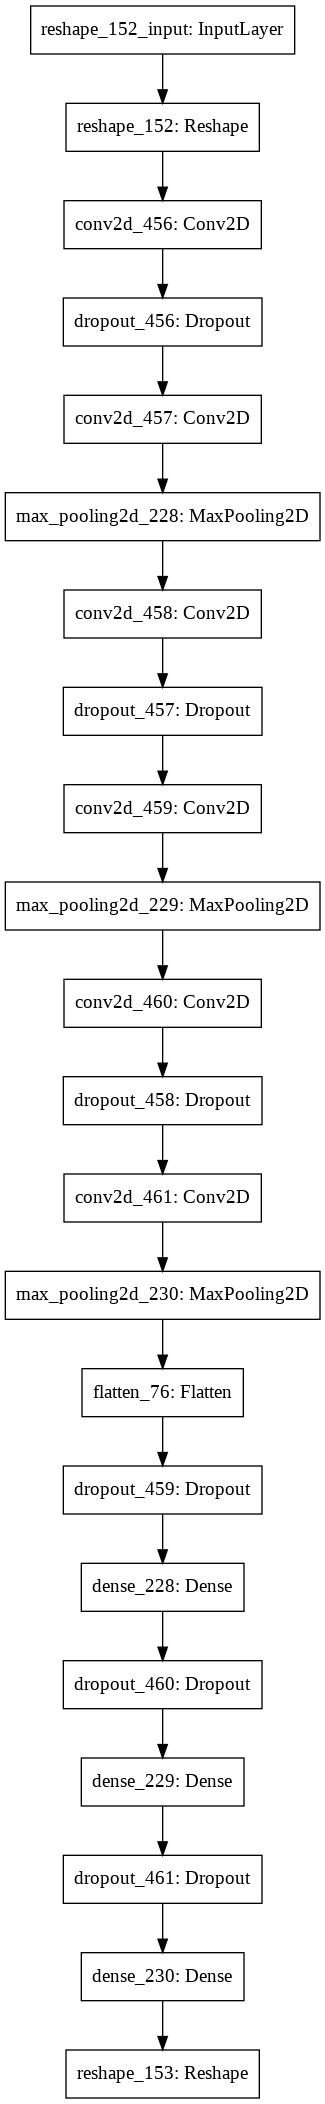

In [148]:

# Vizualizing model structure
# Model summary (ascii)
cnn_n = base_model()

cnn_n.summary()

# Model printout (ascii)
sequential_model_to_ascii_printout(cnn_n)

# Plotting model in graphical mode
plot_model(cnn_n)   ###, to_file='model.png')  ###, show_shapes=True

# **Train DNN** and display results for various jpeg qualities given in jpeg_quality_list

 
 
Extrapolation factor =  0.5
JPEG compression =  [1]
 
 
Figures created
Noise added
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [

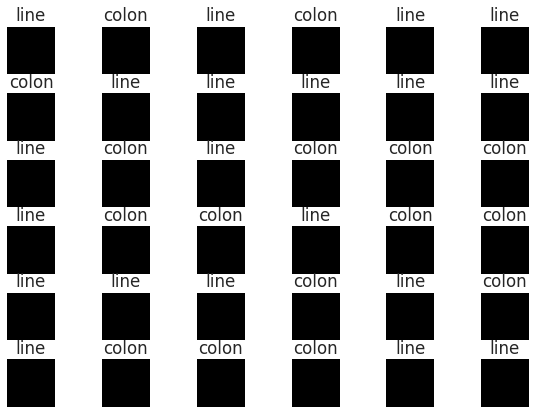

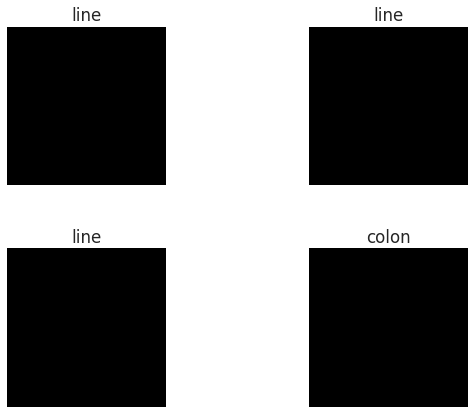

yy_train  (600, 1, 2)
No saved model, training a new one.

Epoch 00001: val_categorical_accuracy improved from -inf to 0.41000, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy improved from 0.41000 to 0.59000, saving model to best_model.h5
Accuracy Train: 50.50% , Test: 59.00% Val: 52.00% 


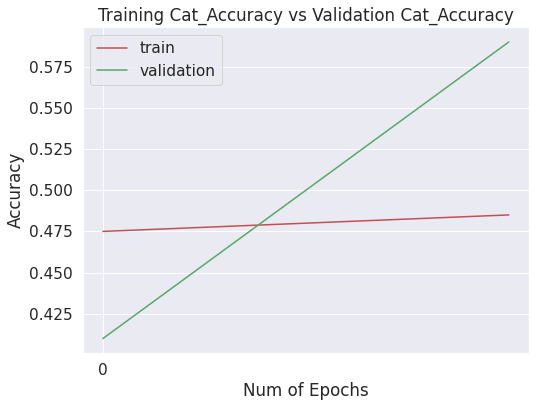

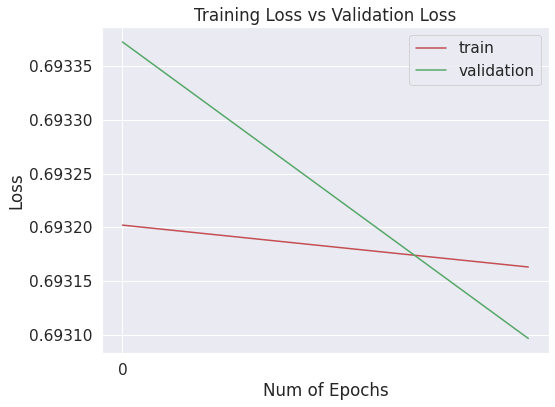

4/4 - 0s
[[52  0]
 [48  0]]


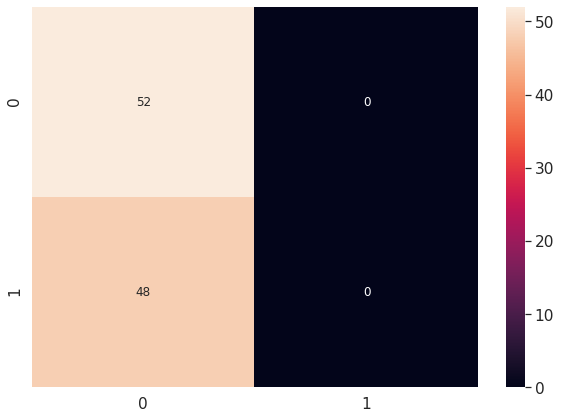

4/4 - 0s


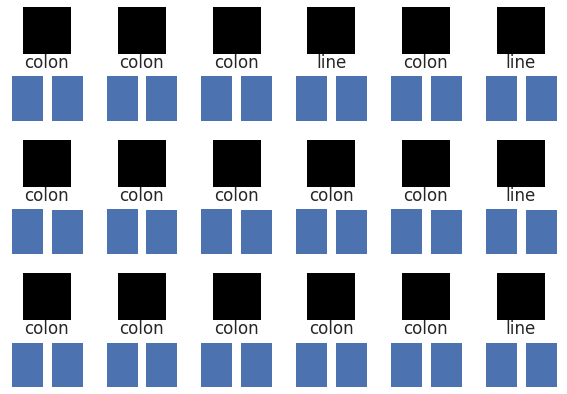

4/4 - 0s


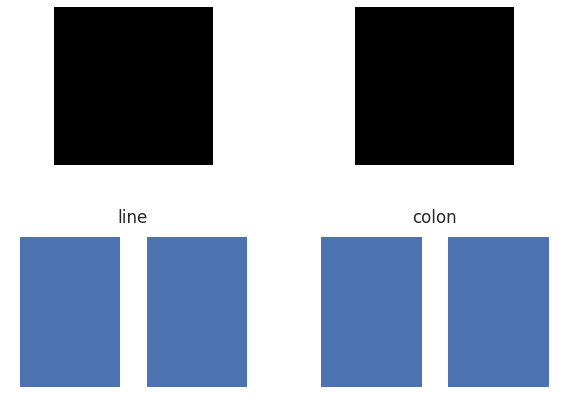

4/4 - 0s


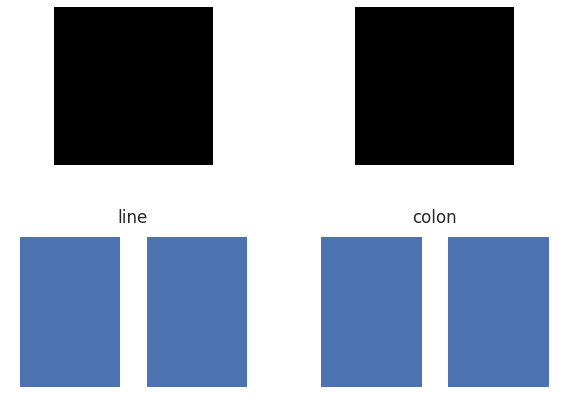

4/4 - 0s


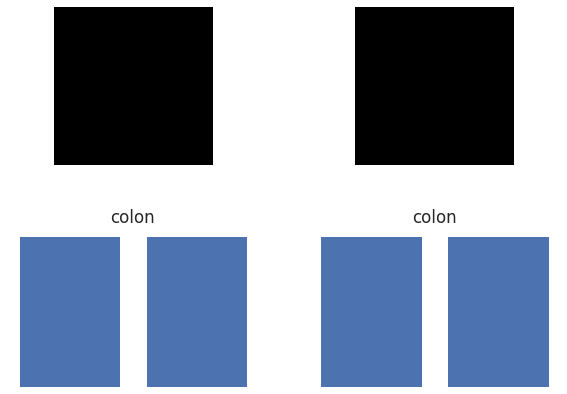

 
 
Extrapolation factor =  0.5
JPEG compression =  [2]
 
 
Figures created
Noise added
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [

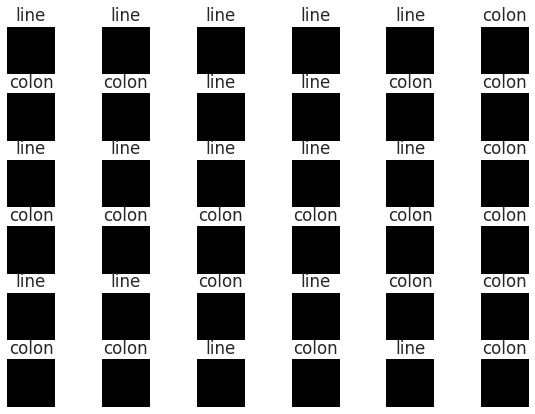

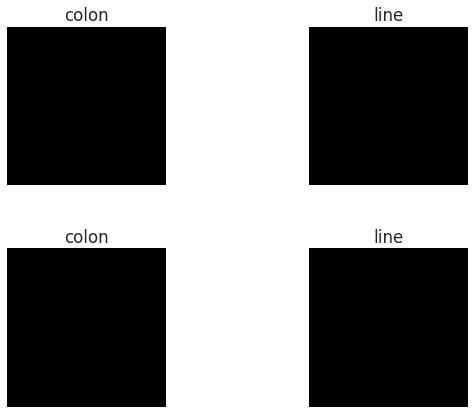

yy_train  (600, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.46000, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.46000
Accuracy Train: 50.17% , Test: 46.00% Val: 51.00% 


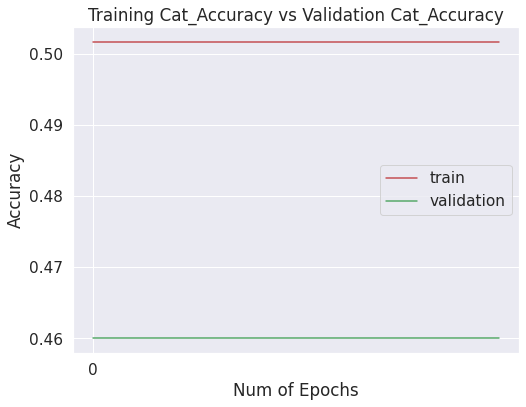

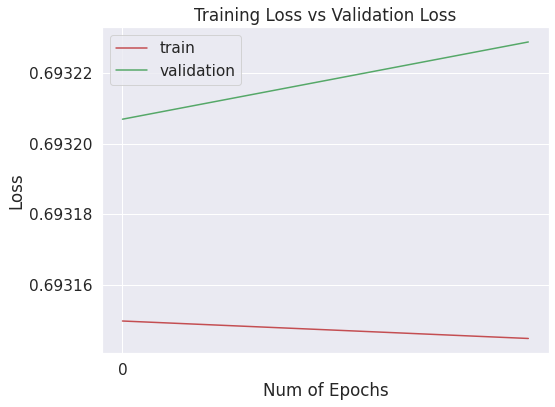

4/4 - 0s
[[51  0]
 [49  0]]


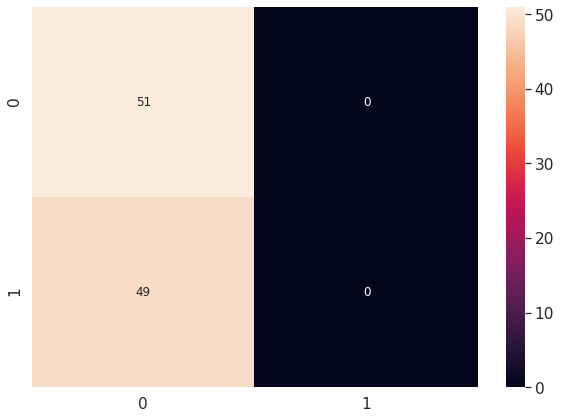

4/4 - 0s


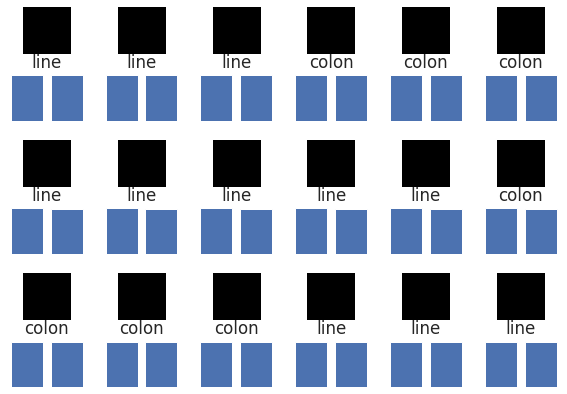

4/4 - 0s


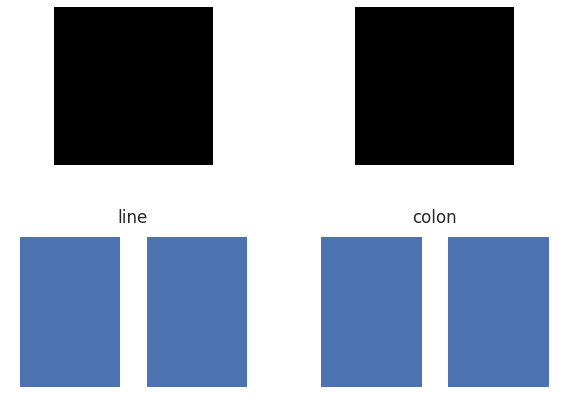

4/4 - 0s


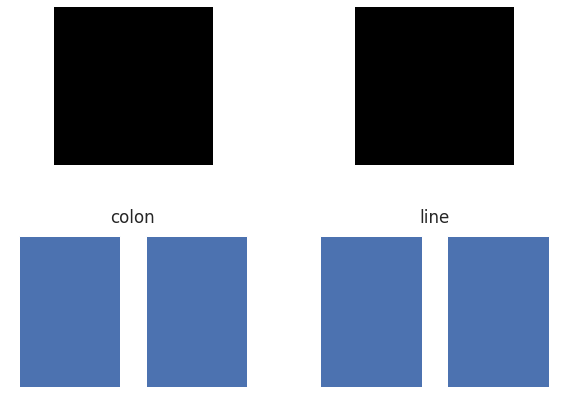

4/4 - 0s


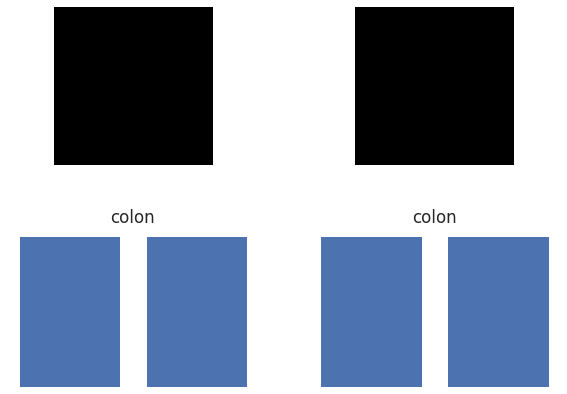

 
 
Extrapolation factor =  0.5
JPEG compression =  [4]
 
 
Figures created
Noise added
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [

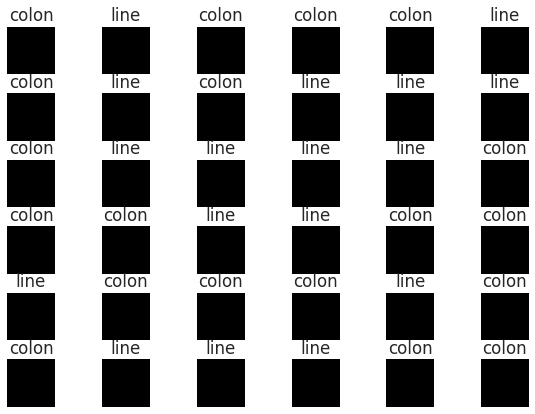

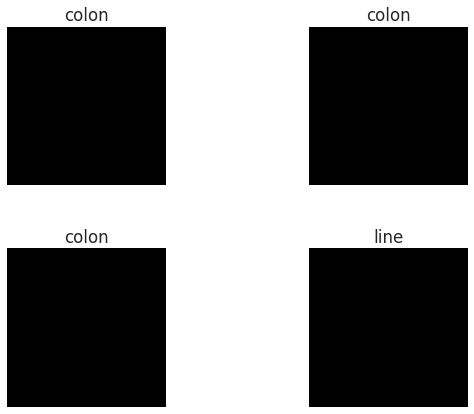

yy_train  (600, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.49000, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.49000
Accuracy Train: 53.00% , Test: 49.00% Val: 52.00% 


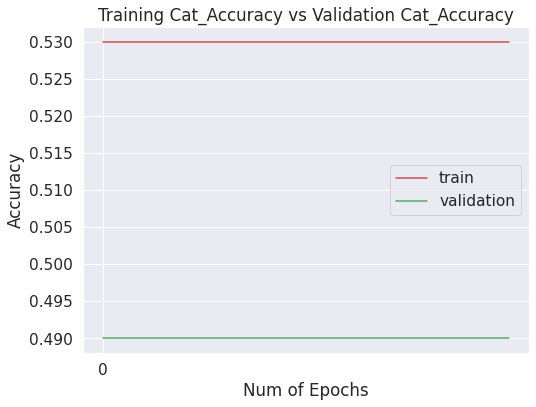

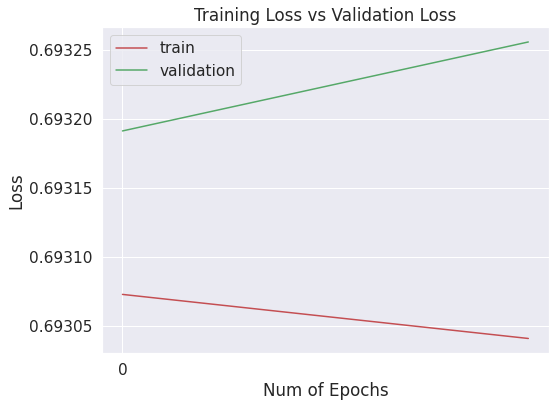

4/4 - 0s
[[52  0]
 [48  0]]


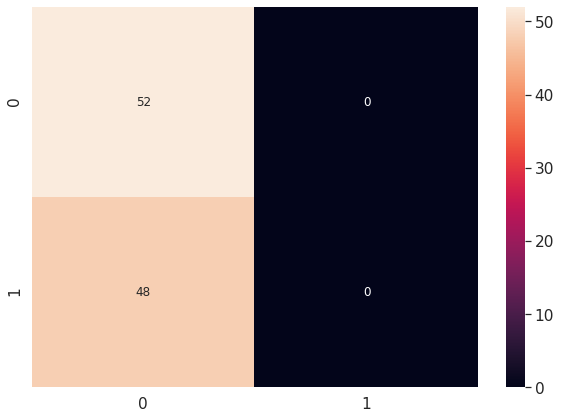

4/4 - 0s


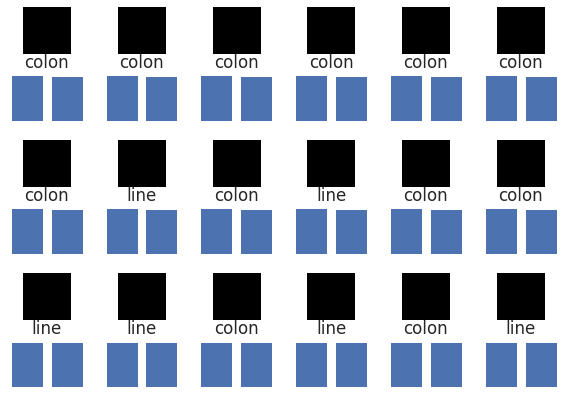

4/4 - 0s


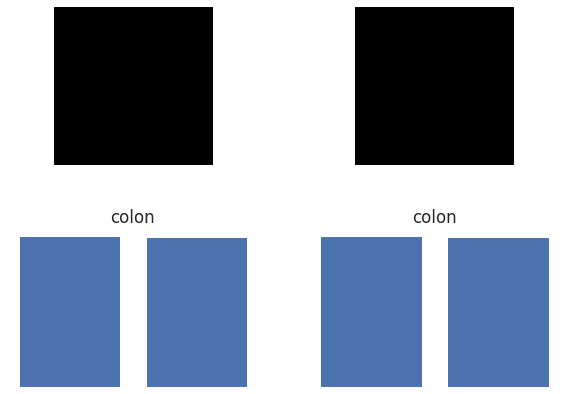

4/4 - 0s


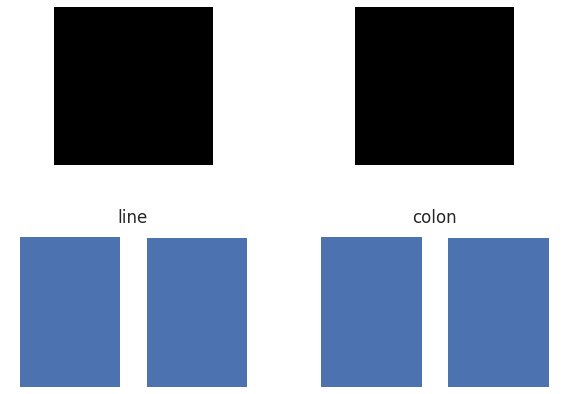

4/4 - 0s


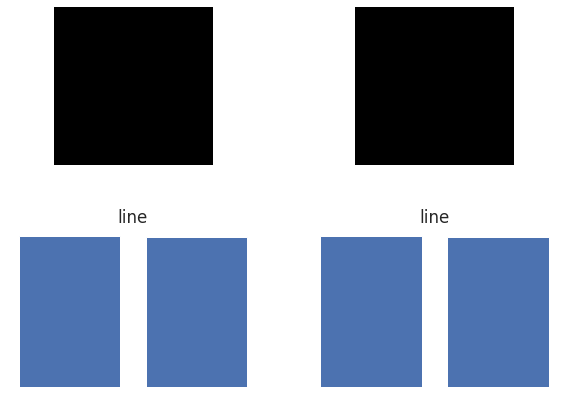

 
 
Extrapolation factor =  0.5
JPEG compression =  [8]
 
 
Figures created
Noise added
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [

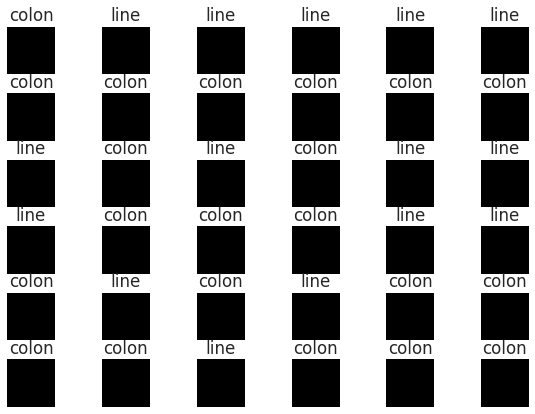

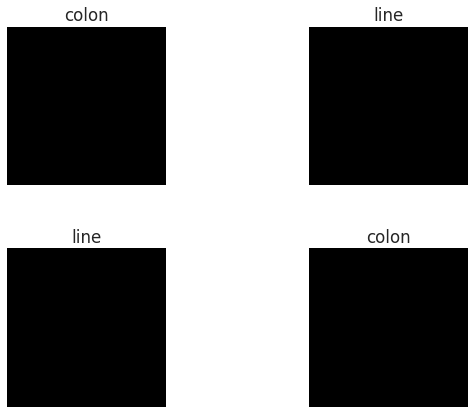

yy_train  (600, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.44000, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.44000
Accuracy Train: 54.17% , Test: 44.00% Val: 41.00% 


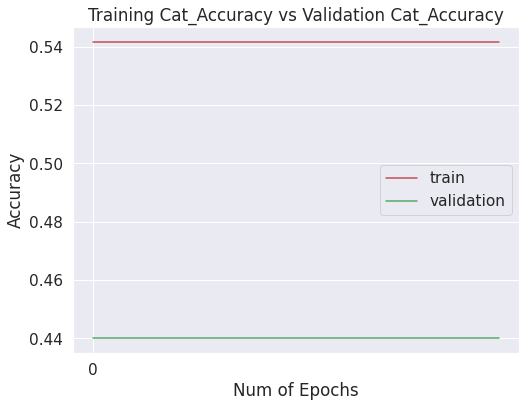

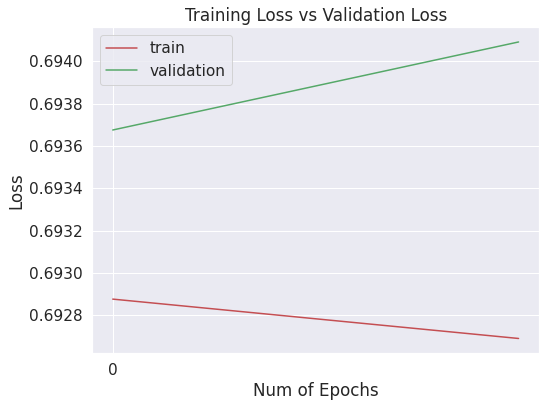

4/4 - 0s
[[41  0]
 [59  0]]


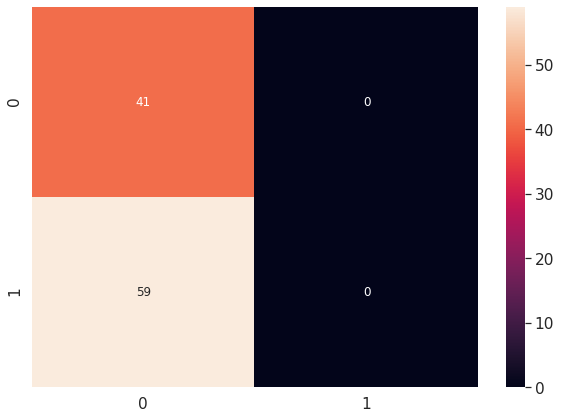

4/4 - 0s


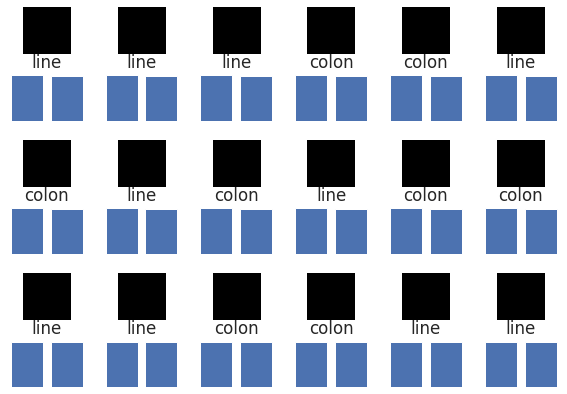

4/4 - 0s


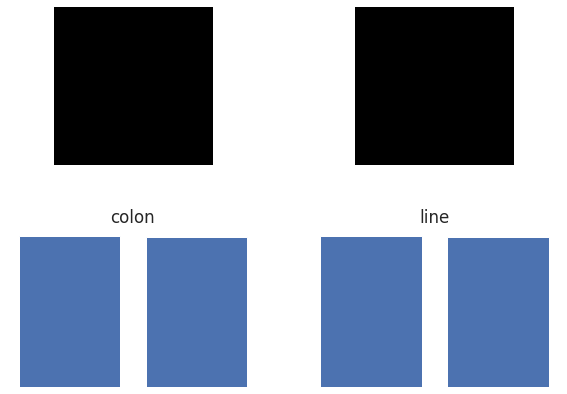

4/4 - 0s


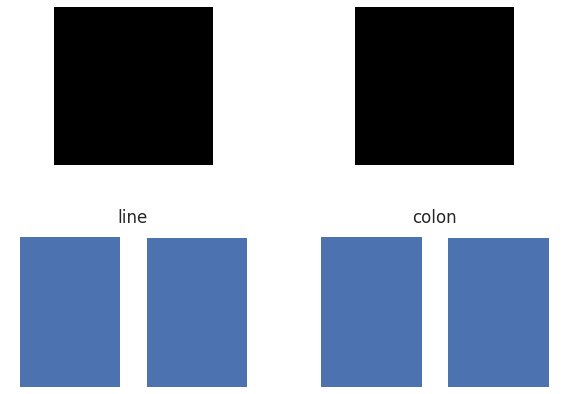

4/4 - 0s


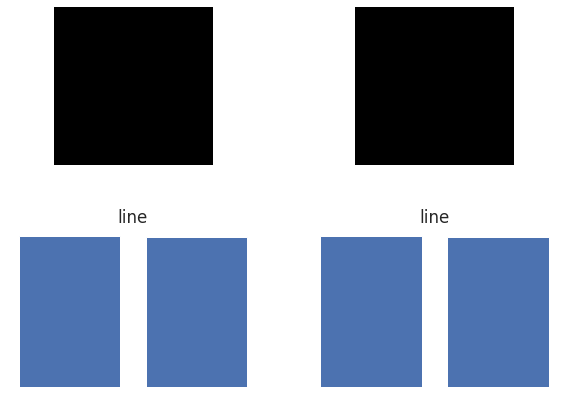

 
 
Extrapolation factor =  0.5
JPEG compression =  [16]
 
 
Figures created
Noise added
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 

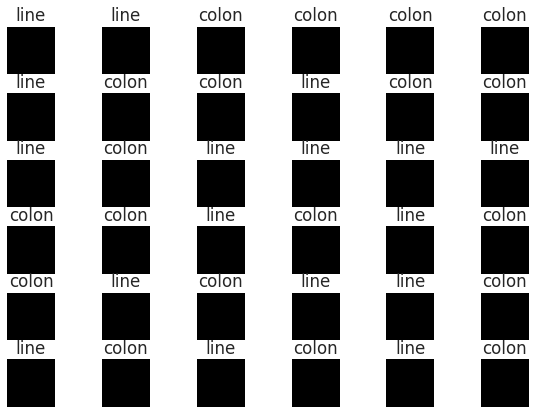

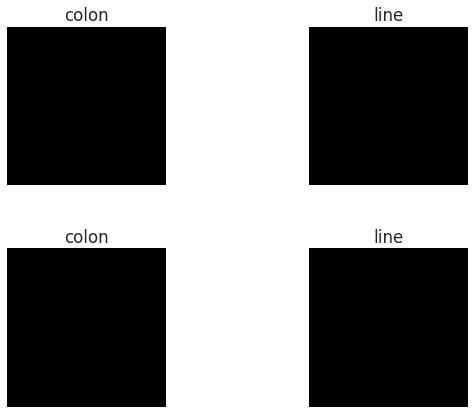

yy_train  (600, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.49000, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.49000
Accuracy Train: 49.67% , Test: 49.00% Val: 54.00% 


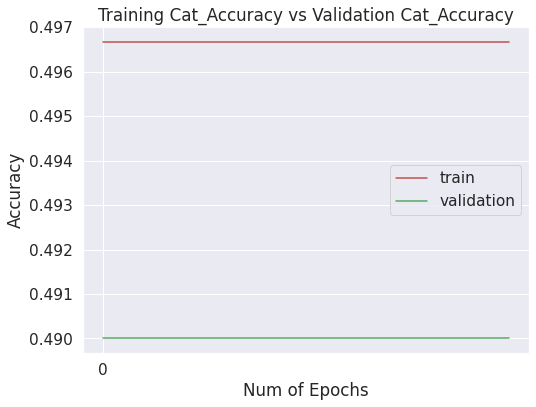

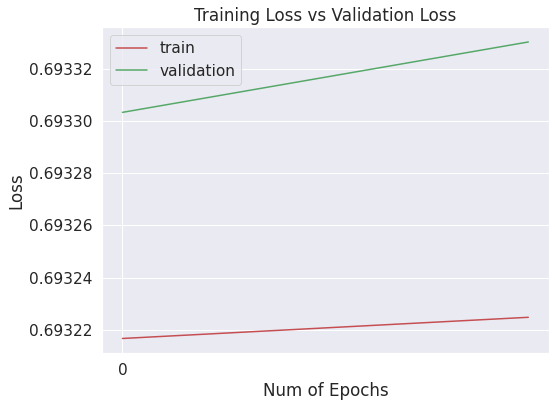

4/4 - 0s
[[54  0]
 [46  0]]


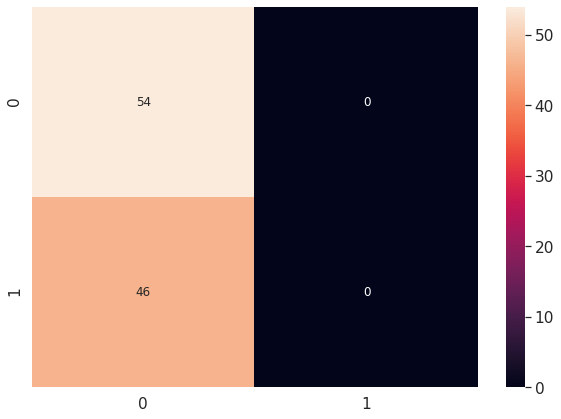

4/4 - 0s


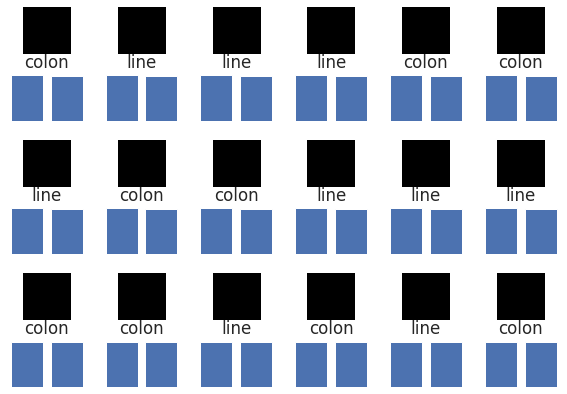

4/4 - 0s


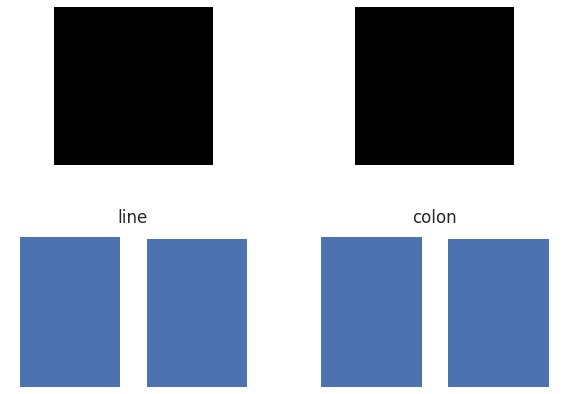

4/4 - 0s


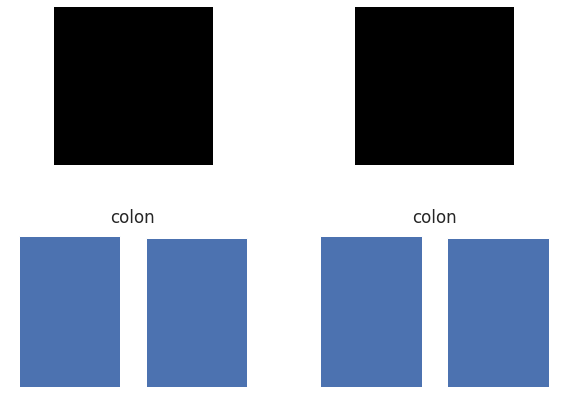

4/4 - 0s


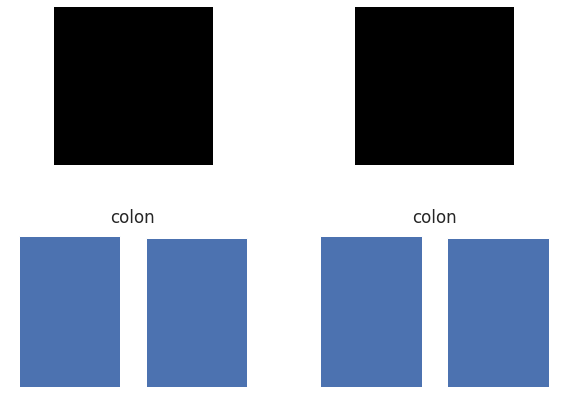

 
 
Extrapolation factor =  0.5
JPEG compression =  [32]
 
 
Figures created
Noise added
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 

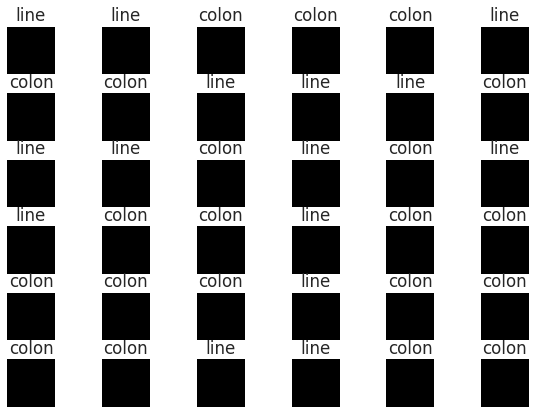

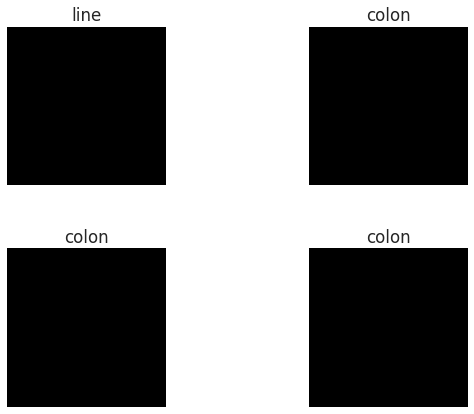

yy_train  (600, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.55000, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.55000
Accuracy Train: 50.50% , Test: 55.00% Val: 43.00% 


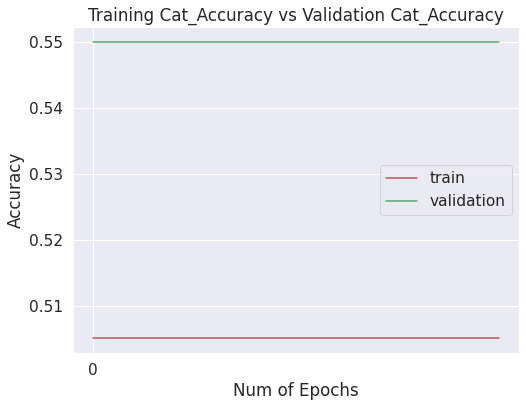

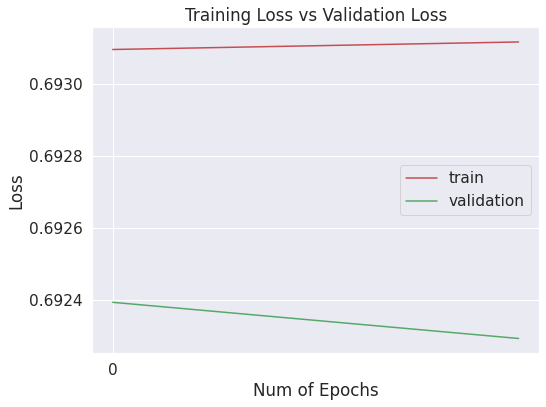

4/4 - 0s
[[43  0]
 [57  0]]


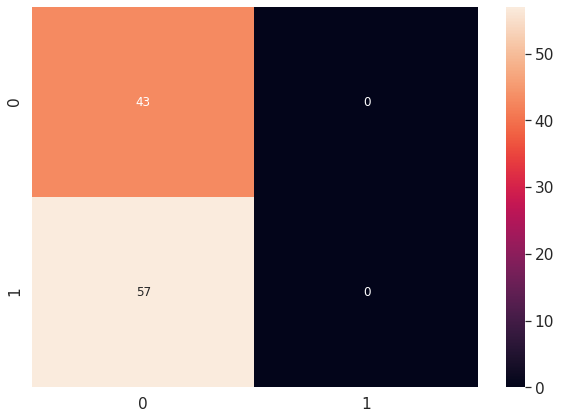

4/4 - 0s


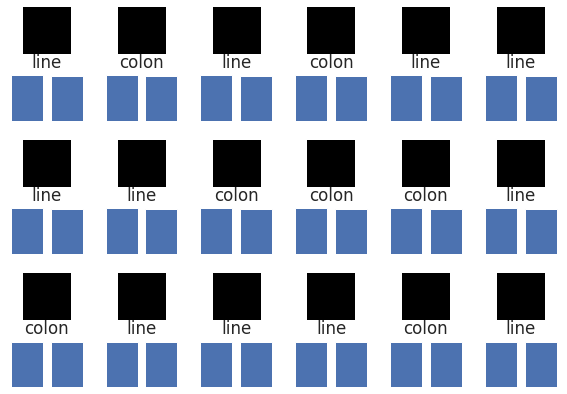

4/4 - 0s


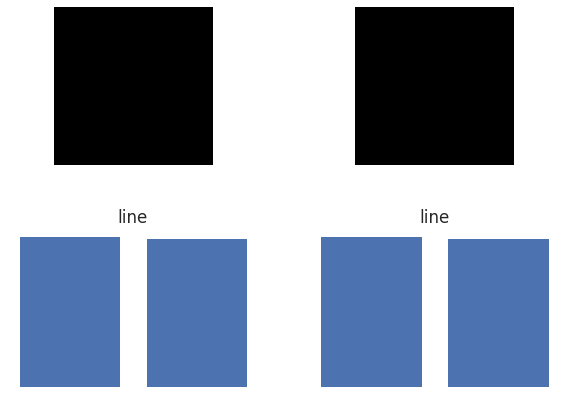

4/4 - 0s


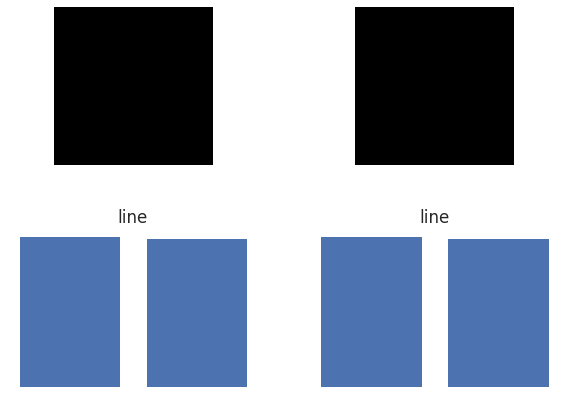

4/4 - 0s


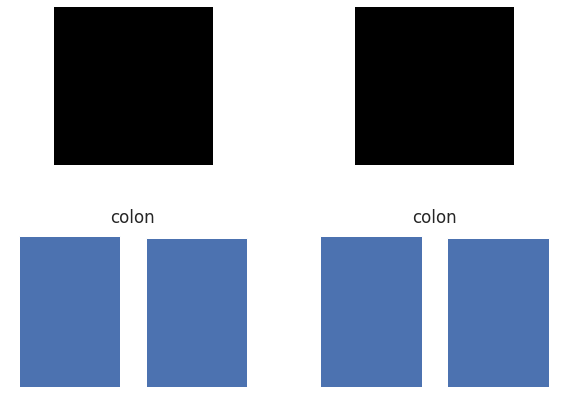

 
 
Extrapolation factor =  1.0
JPEG compression =  [1]
 
 
Figures created
Noise added
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [

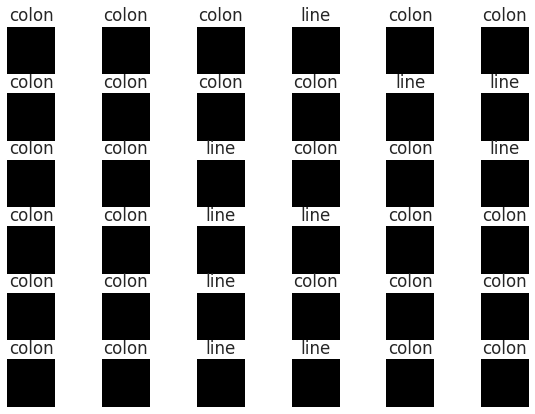

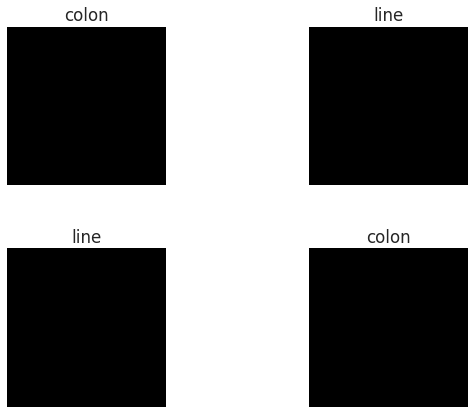

yy_train  (600, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.43000, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.43000
Accuracy Train: 49.67% , Test: 43.00% Val: 44.00% 


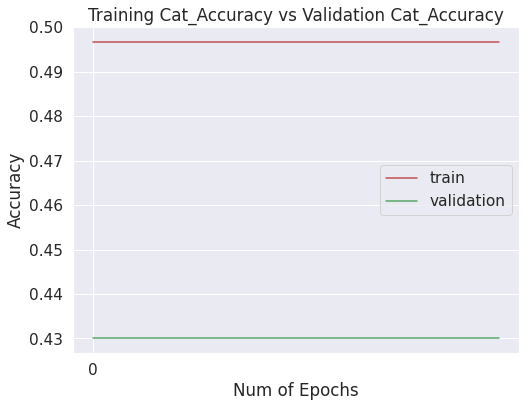

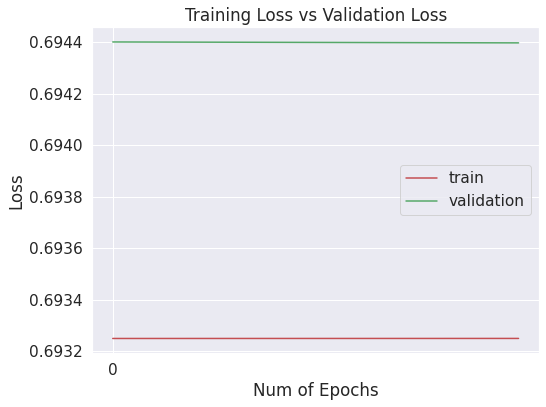

4/4 - 0s
[[44  0]
 [56  0]]


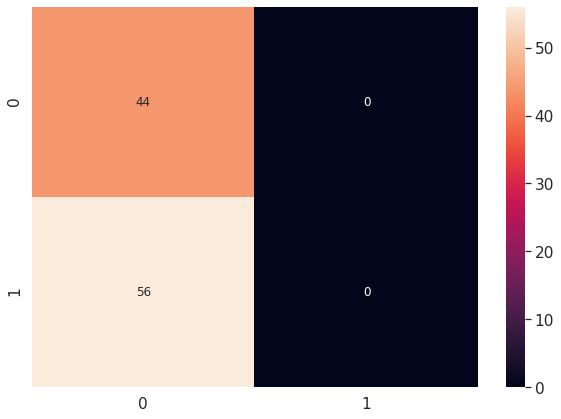

4/4 - 0s


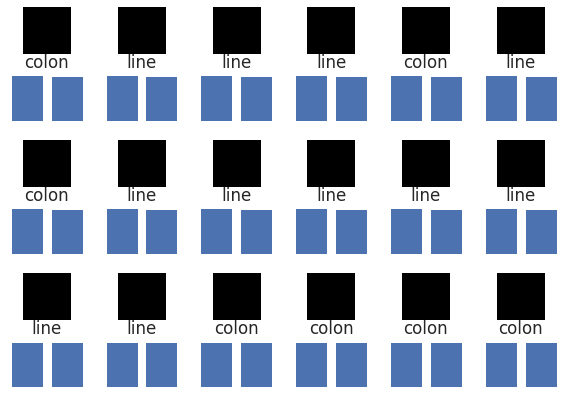

4/4 - 0s


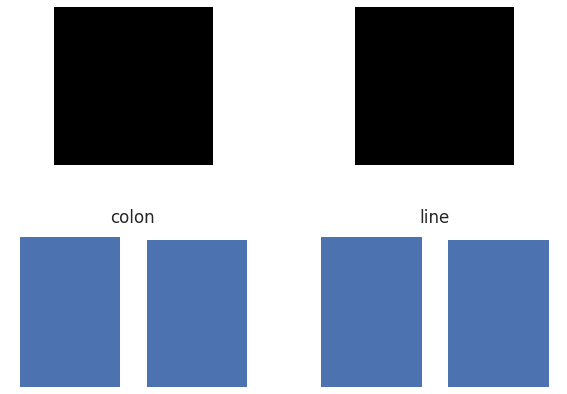

4/4 - 0s


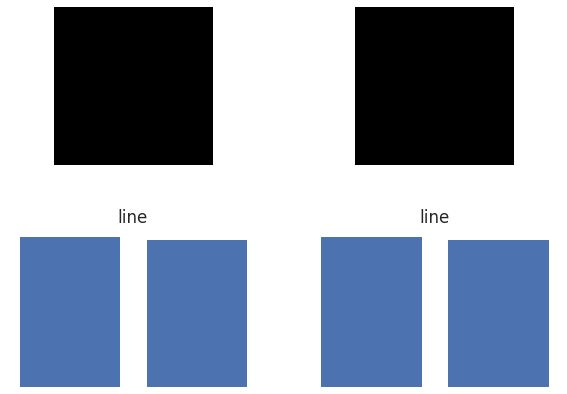

4/4 - 0s


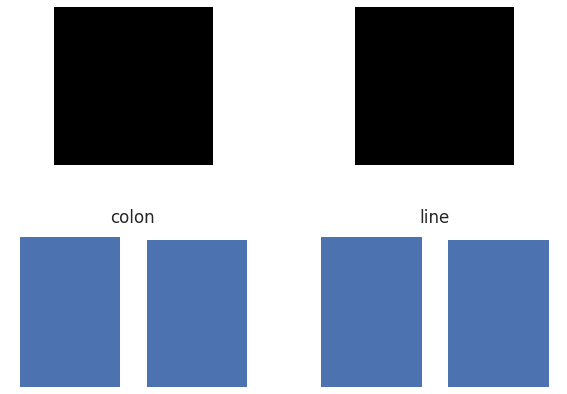

 
 
Extrapolation factor =  1.0
JPEG compression =  [2]
 
 
Figures created
Noise added
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [

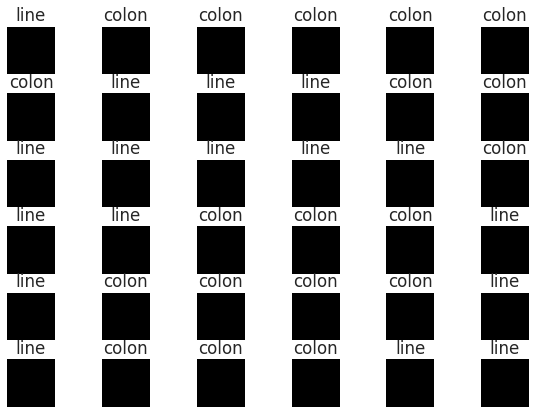

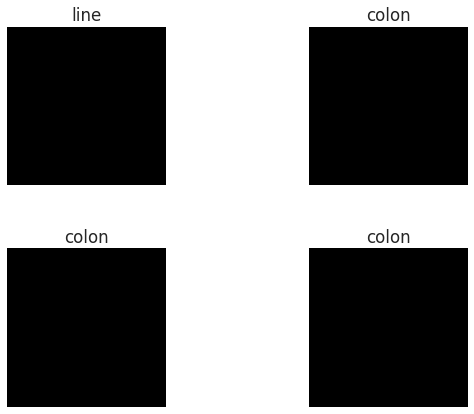

yy_train  (600, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.56000, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.56000
Accuracy Train: 51.33% , Test: 56.00% Val: 57.00% 


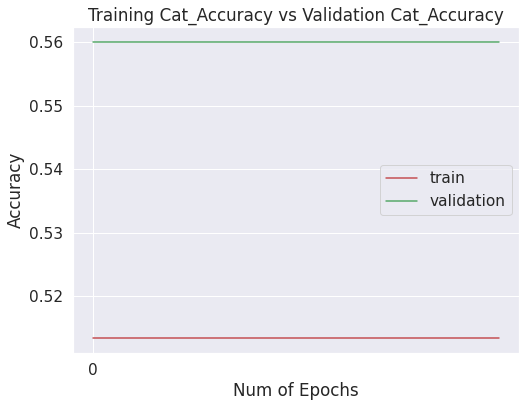

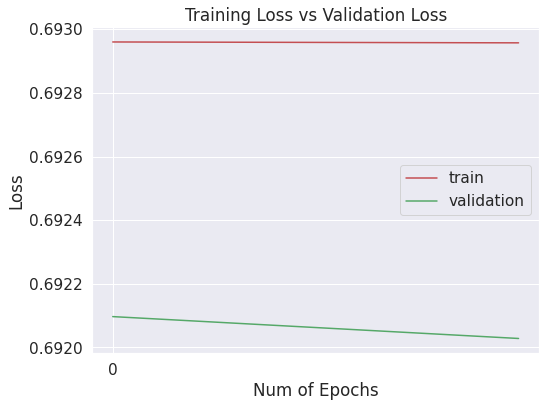

4/4 - 0s
[[57  0]
 [43  0]]


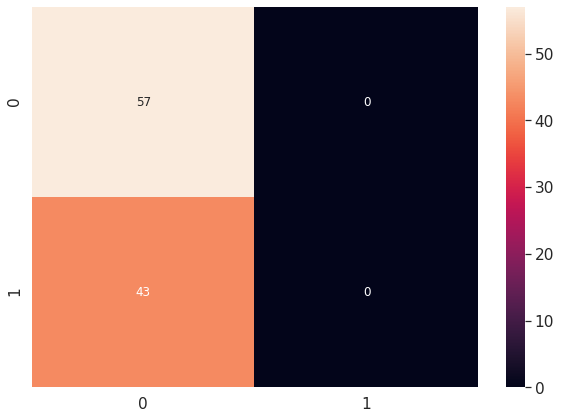

4/4 - 0s


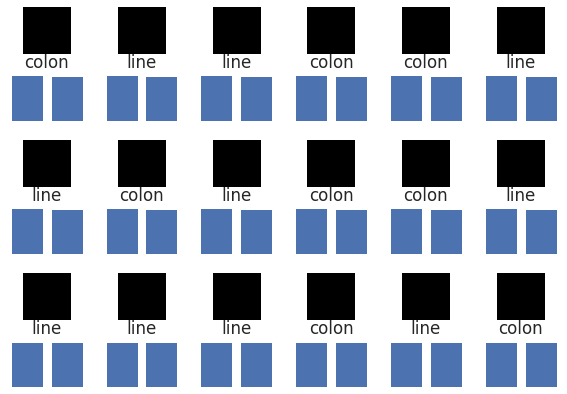

4/4 - 0s


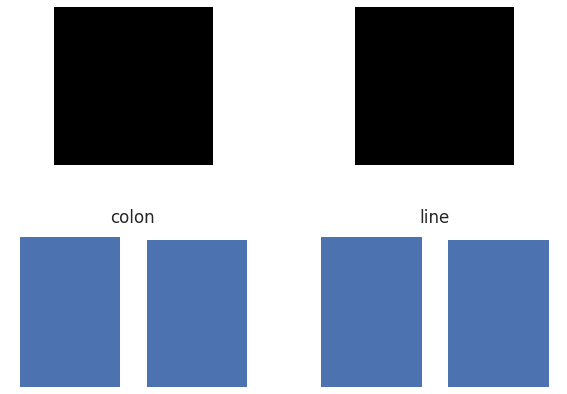

4/4 - 0s


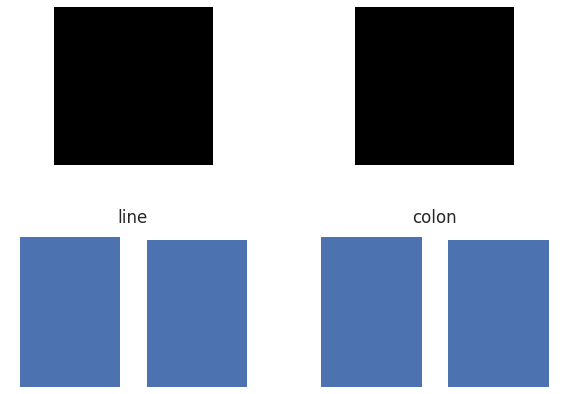

4/4 - 0s


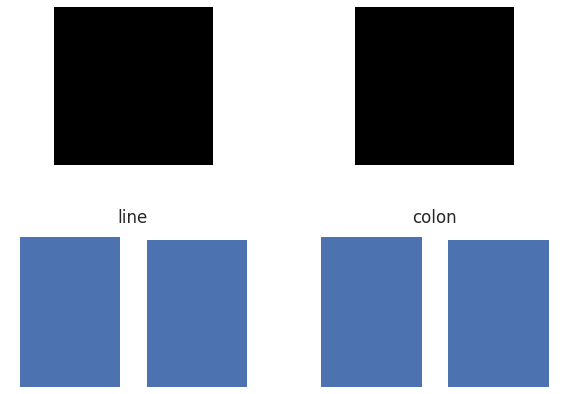

 
 
Extrapolation factor =  1.0
JPEG compression =  [4]
 
 
Figures created
Noise added
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [

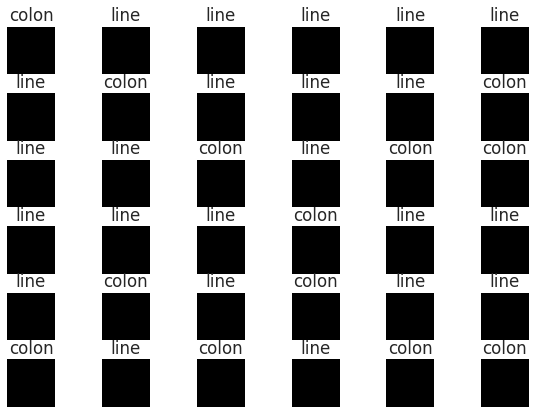

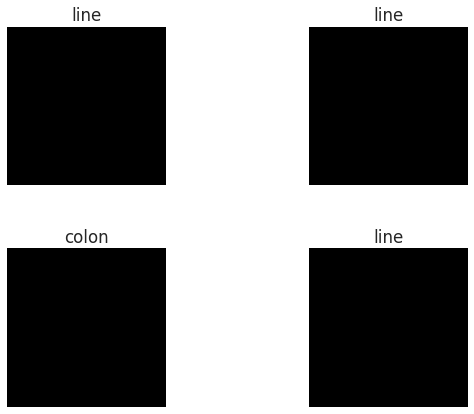

yy_train  (600, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.43000, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.43000
Accuracy Train: 49.50% , Test: 43.00% Val: 43.00% 


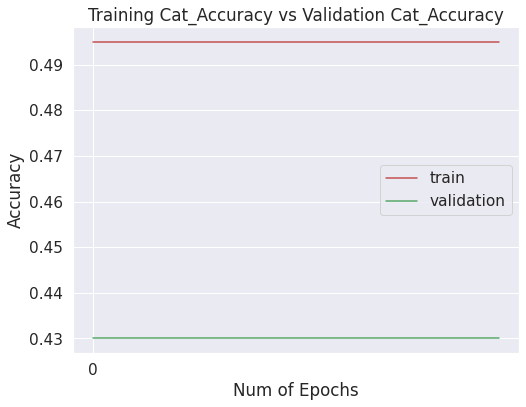

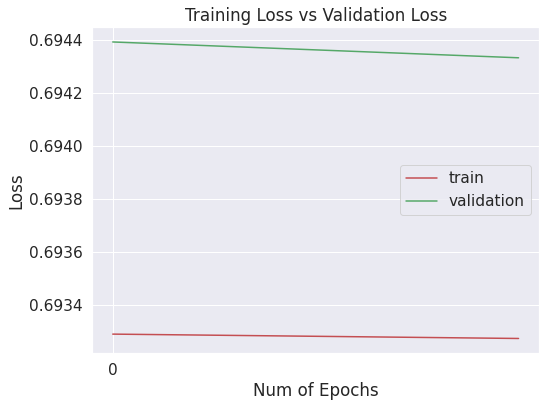

4/4 - 0s
[[43  0]
 [57  0]]


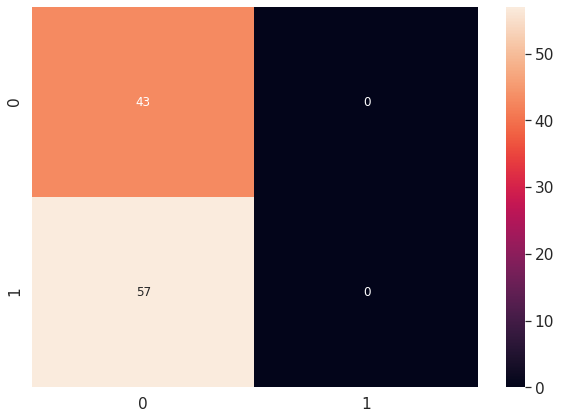

4/4 - 0s


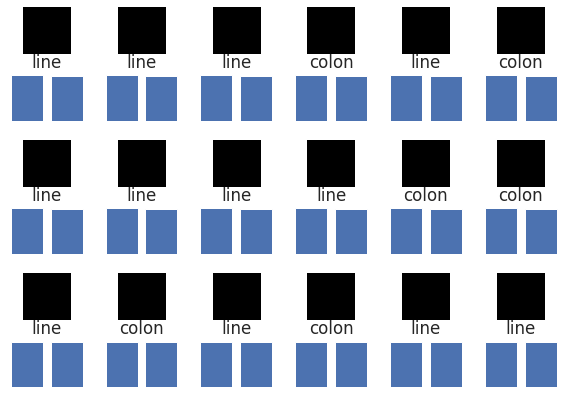

4/4 - 0s


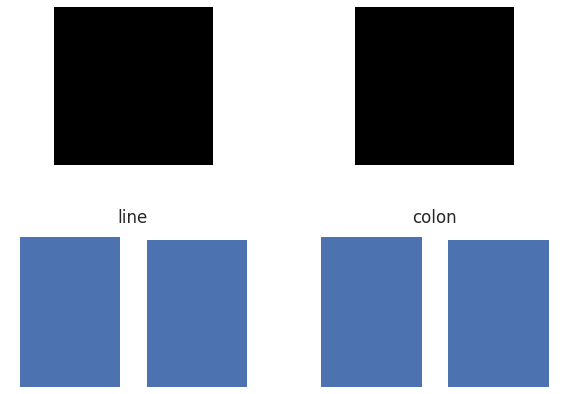

4/4 - 0s


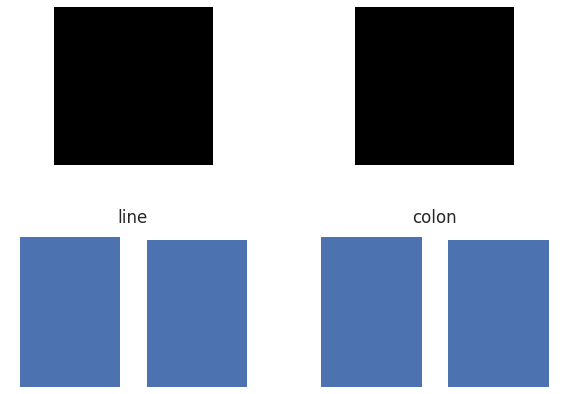

4/4 - 0s


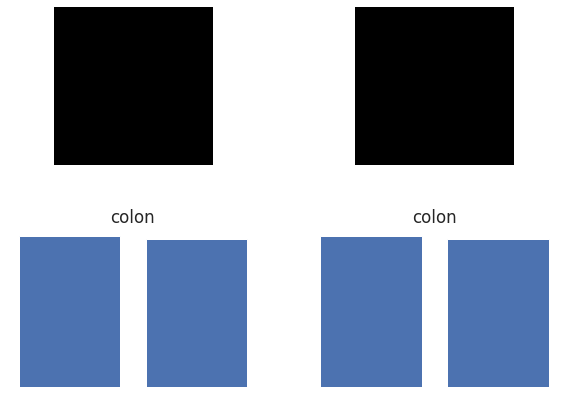

 
 
Extrapolation factor =  1.0
JPEG compression =  [8]
 
 
Figures created
Noise added
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [

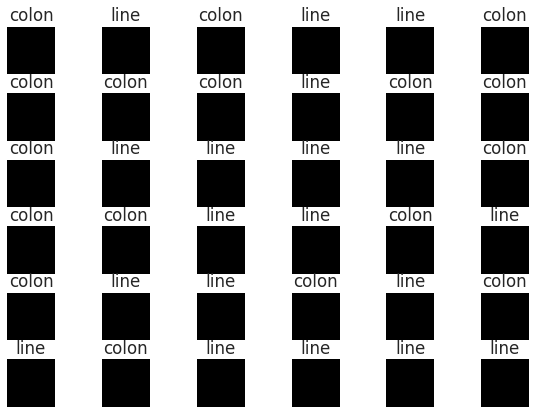

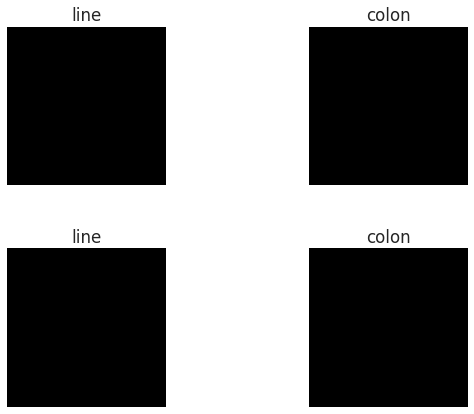

yy_train  (600, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.46000, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.46000
Accuracy Train: 52.50% , Test: 46.00% Val: 51.00% 


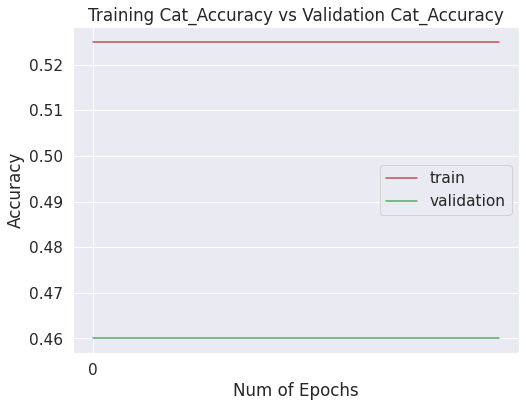

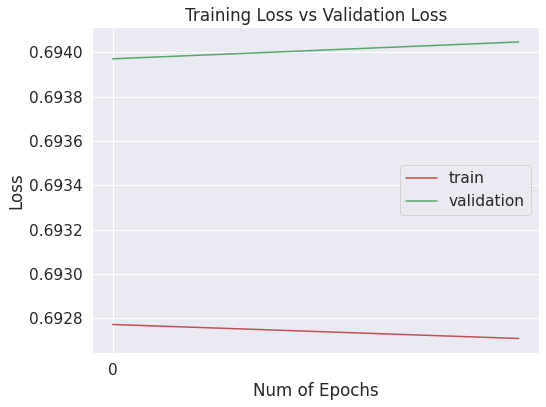

4/4 - 0s
[[51  0]
 [49  0]]


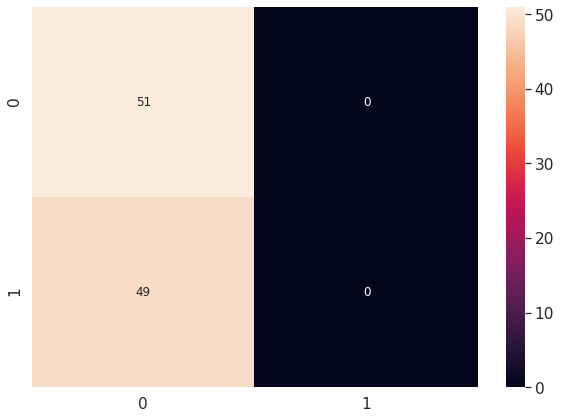

4/4 - 0s


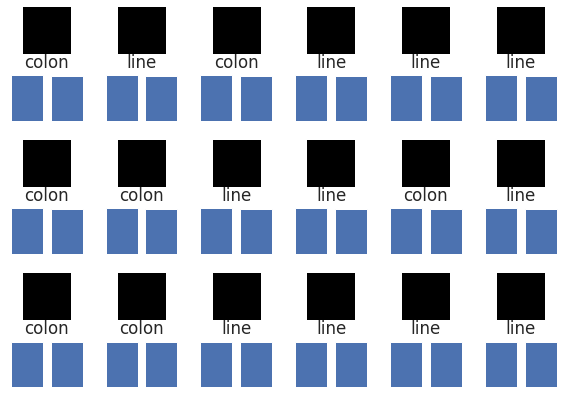

4/4 - 0s


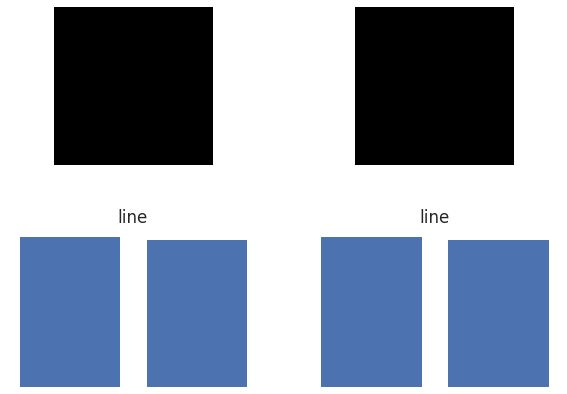

4/4 - 0s


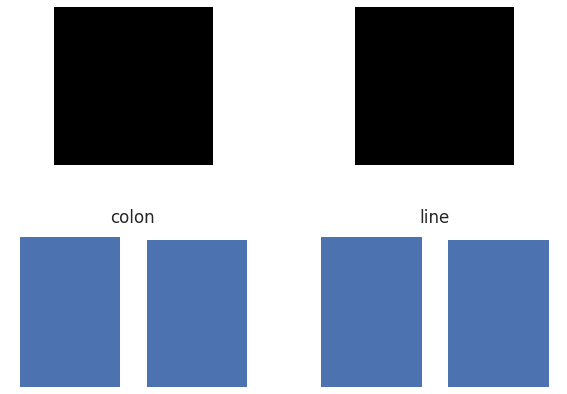

4/4 - 0s


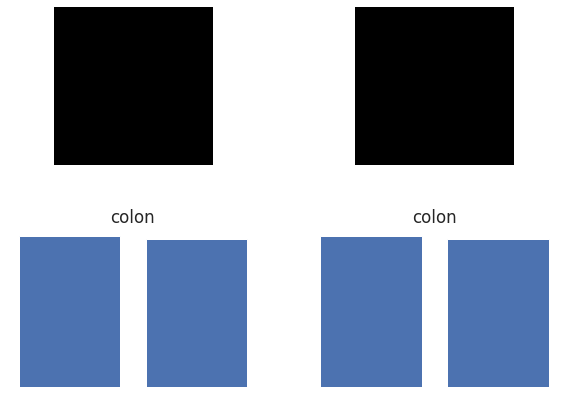

 
 
Extrapolation factor =  1.0
JPEG compression =  [16]
 
 
Figures created
Noise added
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 

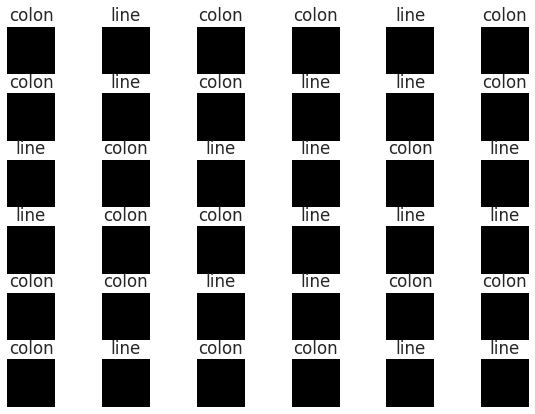

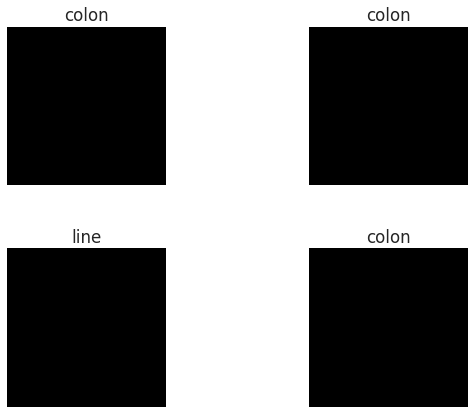

yy_train  (600, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.42000, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.42000
Accuracy Train: 49.83% , Test: 42.00% Val: 56.00% 


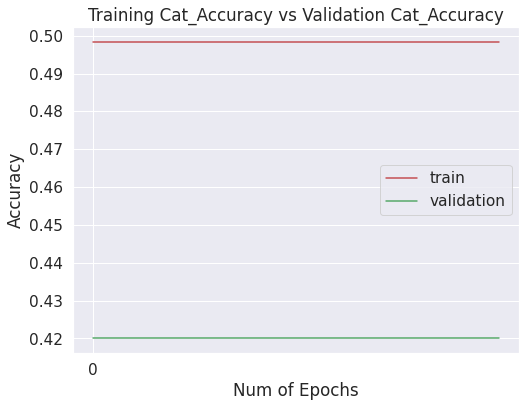

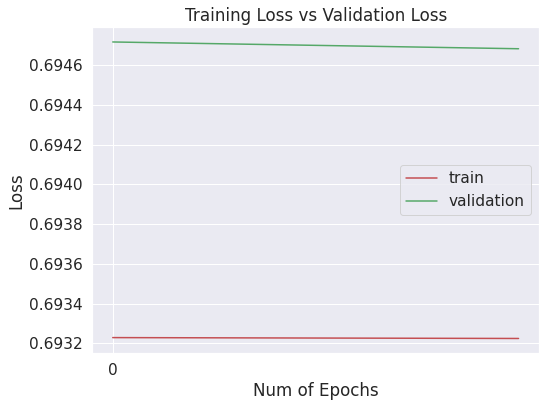

4/4 - 0s
[[56  0]
 [44  0]]


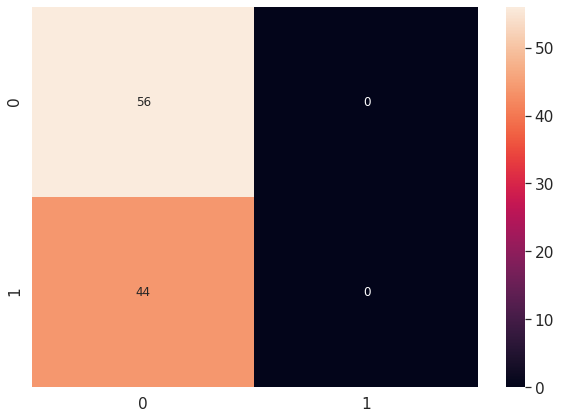

4/4 - 0s


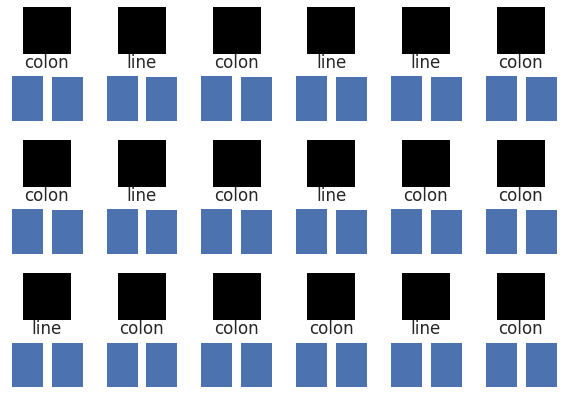

4/4 - 0s


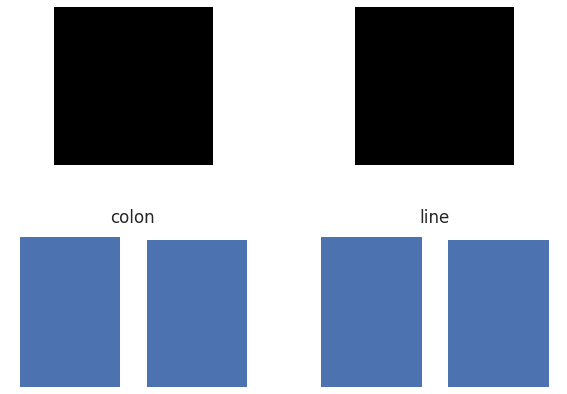

4/4 - 0s


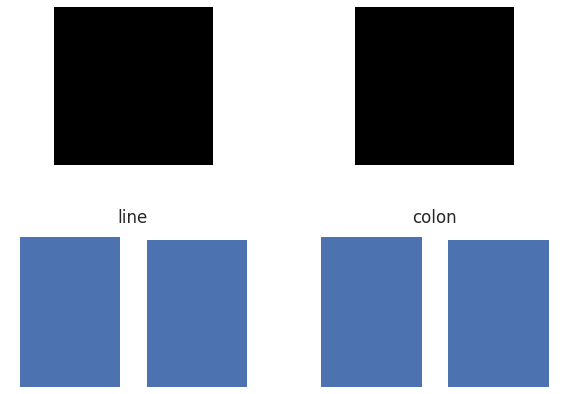

4/4 - 0s


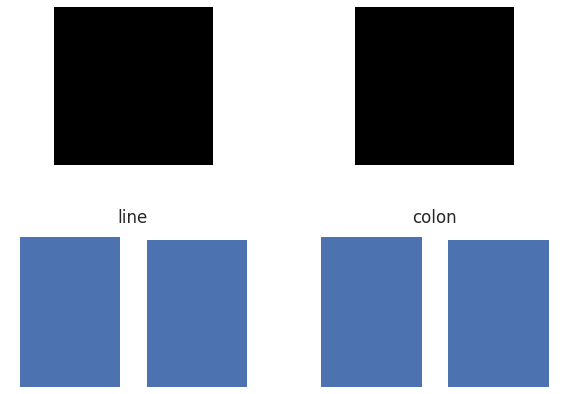

 
 
Extrapolation factor =  1.0
JPEG compression =  [32]
 
 
Figures created
Noise added
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 

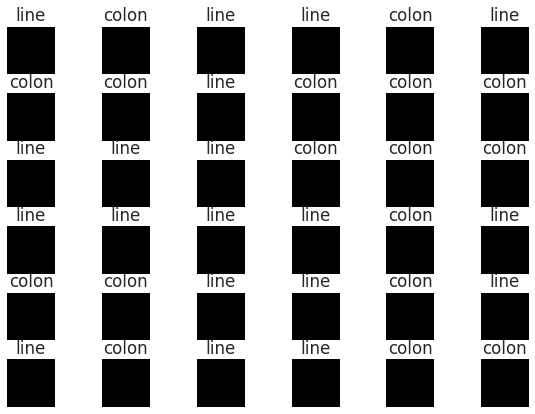

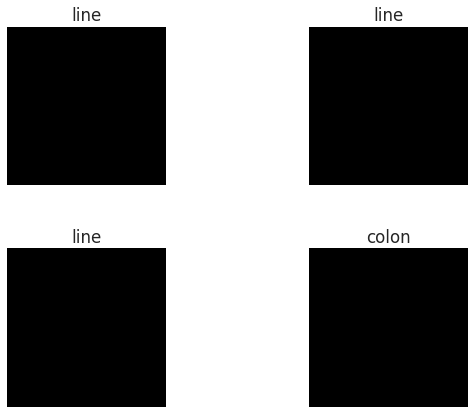

yy_train  (600, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.49000, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.49000
Accuracy Train: 50.83% , Test: 49.00% Val: 53.00% 


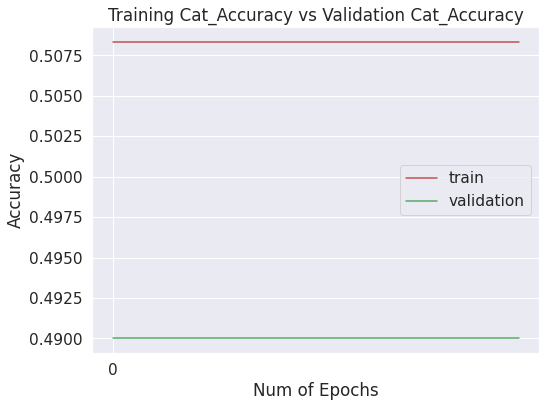

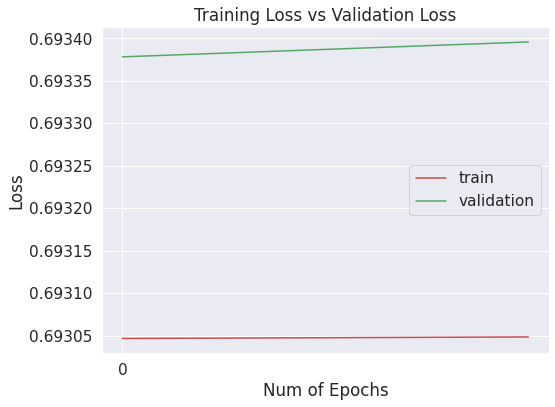

4/4 - 0s
[[53  0]
 [47  0]]


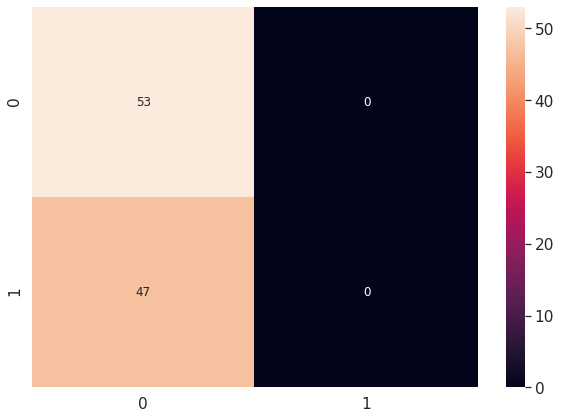

4/4 - 0s


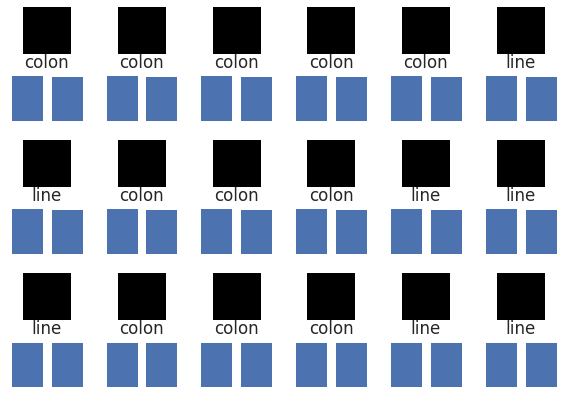

4/4 - 0s


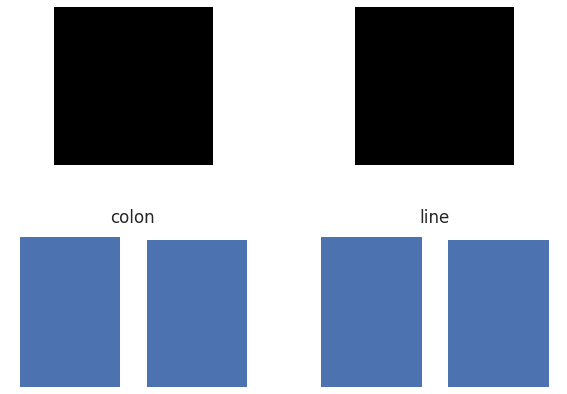

4/4 - 0s


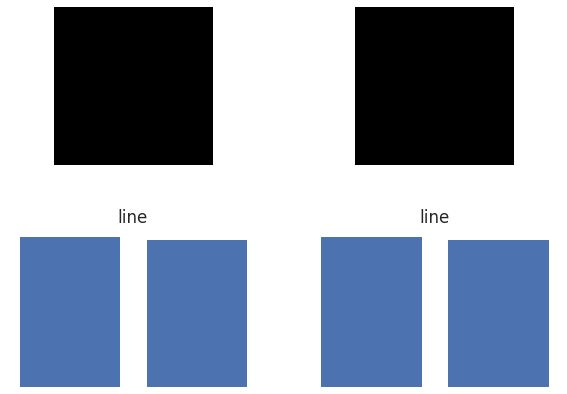

4/4 - 0s


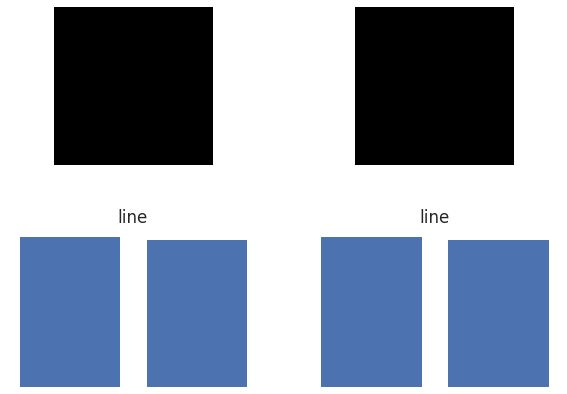

 
 
Extrapolation factor =  2.0
JPEG compression =  [1]
 
 
Figures created
Noise added
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [

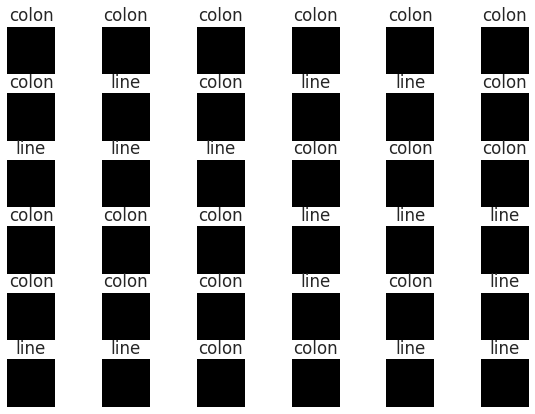

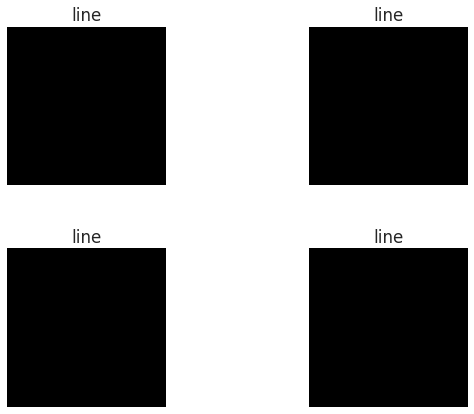

yy_train  (600, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.55000, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.55000
Accuracy Train: 51.83% , Test: 55.00% Val: 54.00% 


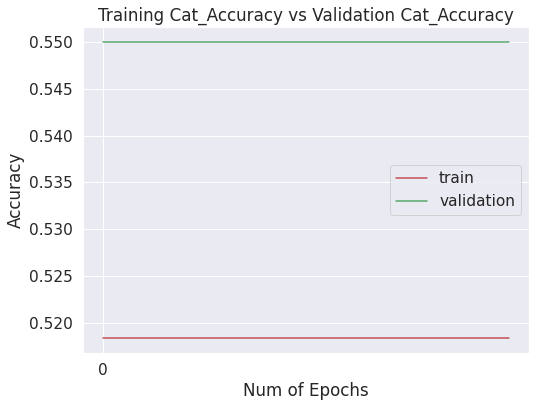

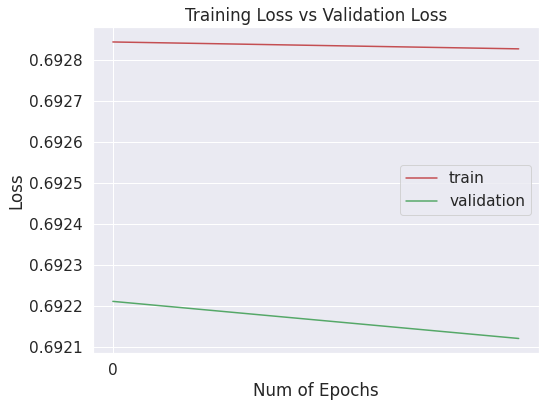

4/4 - 0s
[[54  0]
 [46  0]]


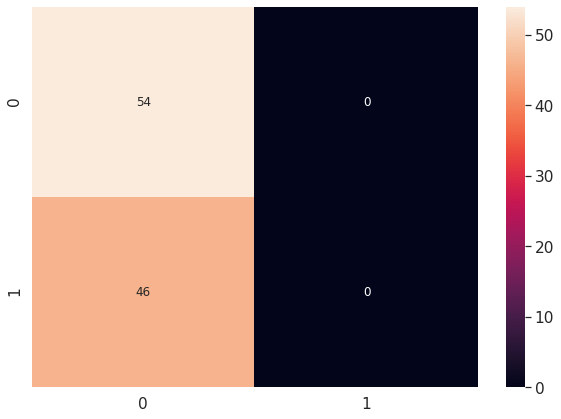

4/4 - 0s


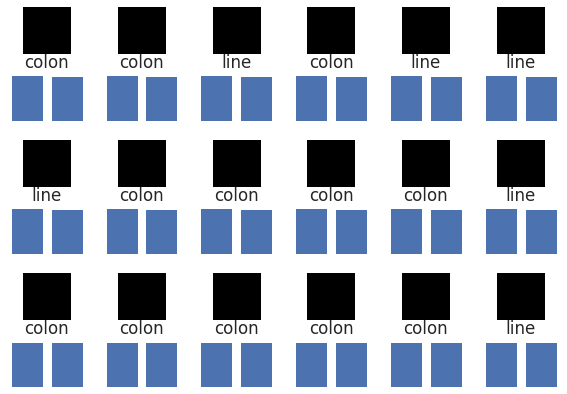

4/4 - 0s


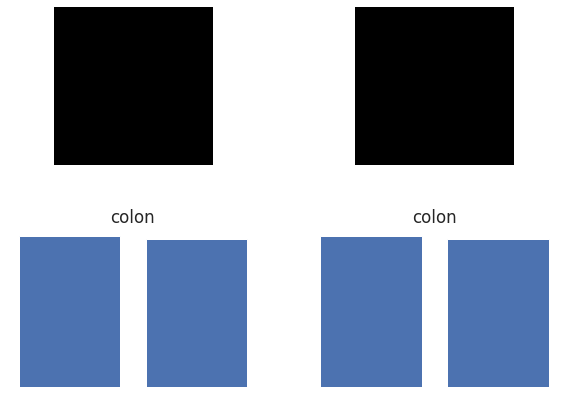

4/4 - 0s


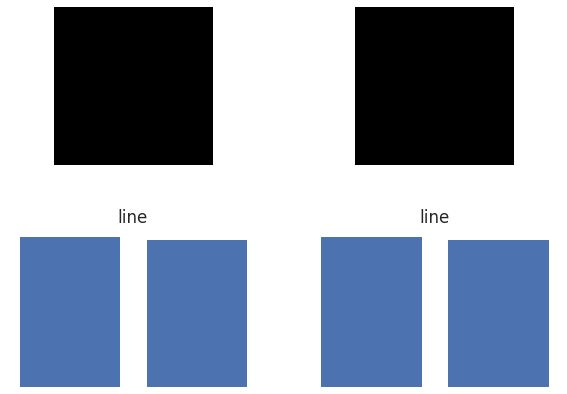

4/4 - 0s


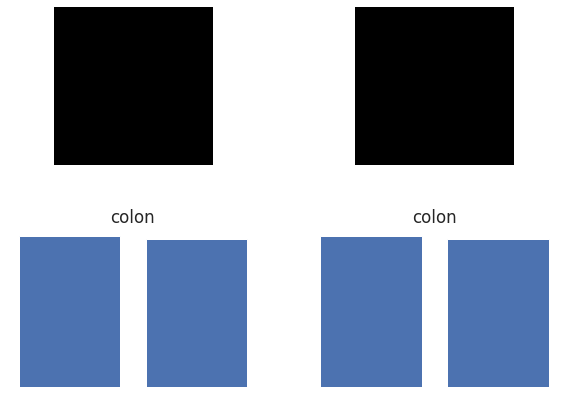

 
 
Extrapolation factor =  2.0
JPEG compression =  [2]
 
 
Figures created
Noise added
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [

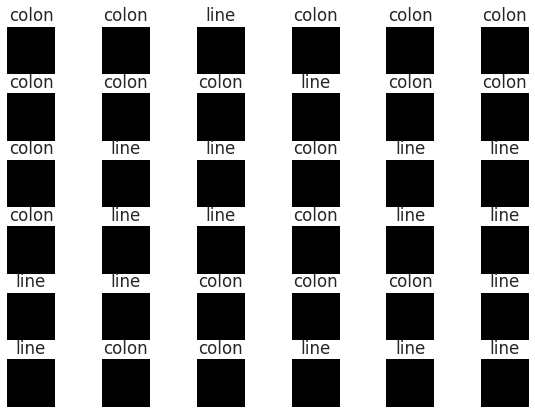

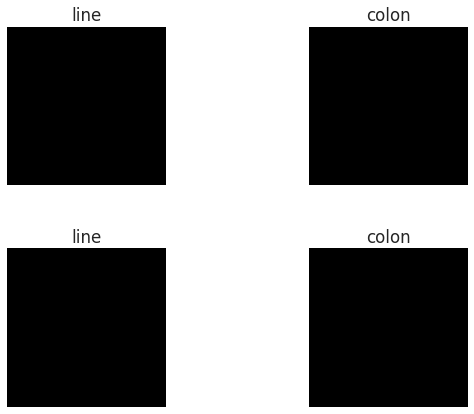

yy_train  (600, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.62000, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.62000
Accuracy Train: 51.83% , Test: 62.00% Val: 47.00% 


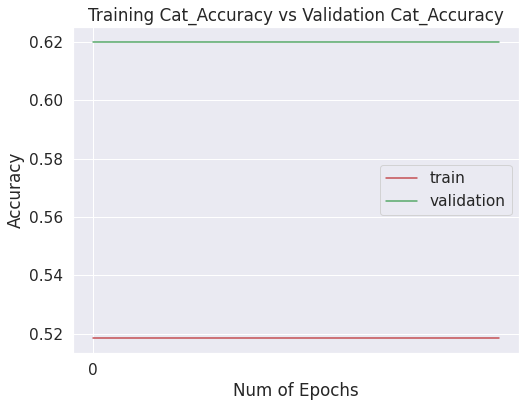

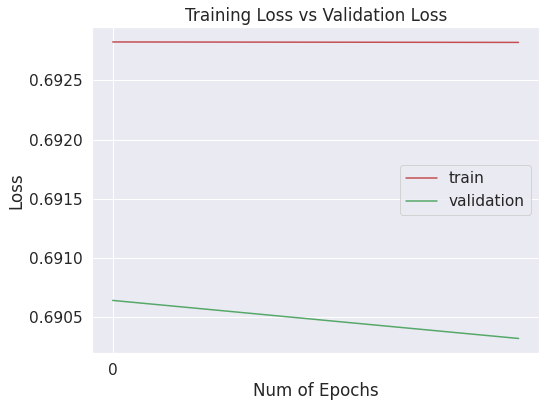

4/4 - 0s
[[47  0]
 [53  0]]


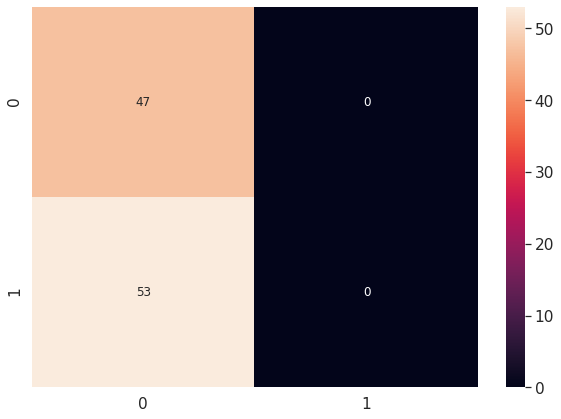

4/4 - 0s


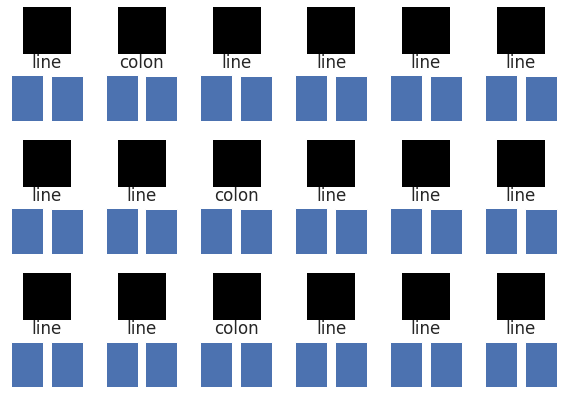

4/4 - 0s


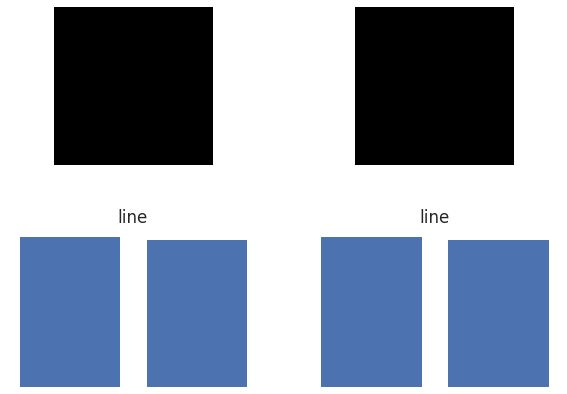

4/4 - 0s


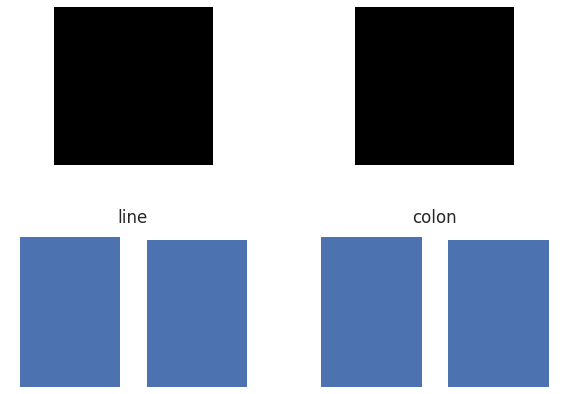

4/4 - 0s


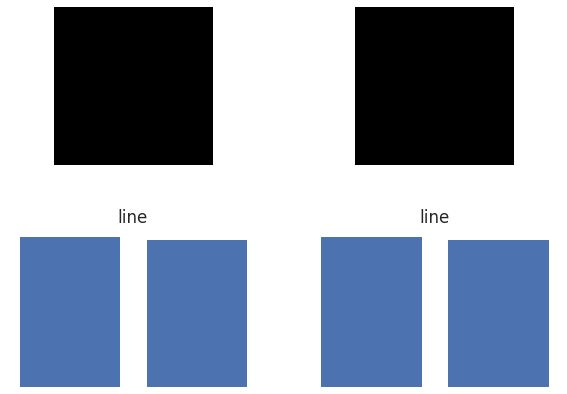

 
 
Extrapolation factor =  2.0
JPEG compression =  [4]
 
 
Figures created
Noise added
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [

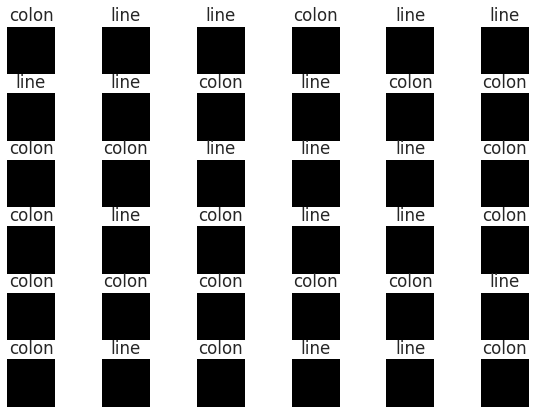

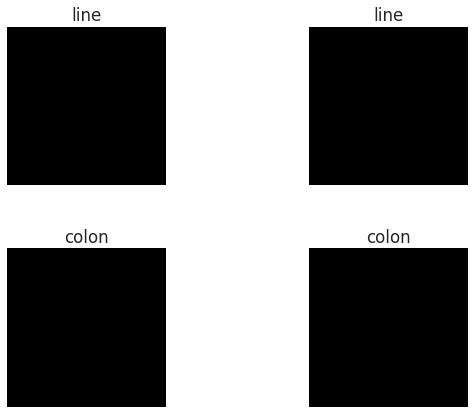

yy_train  (600, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.53000, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.53000
Accuracy Train: 49.50% , Test: 53.00% Val: 40.00% 


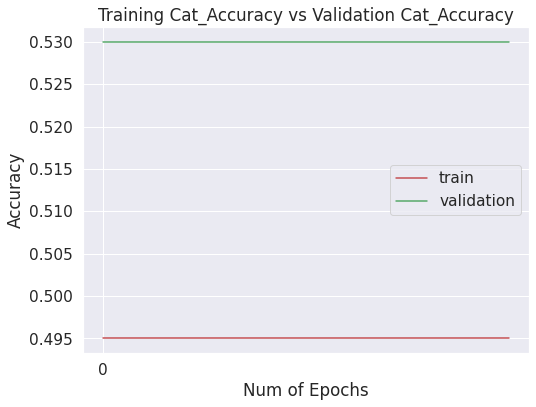

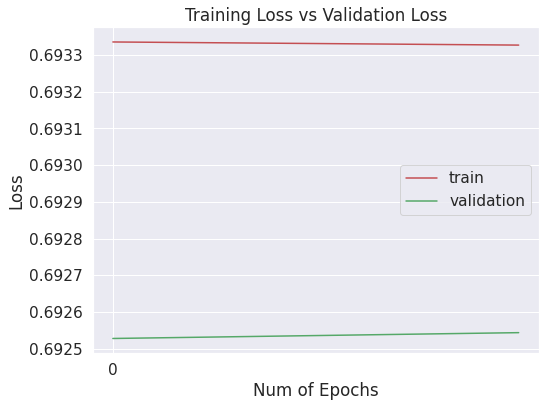

4/4 - 0s
[[40  0]
 [60  0]]


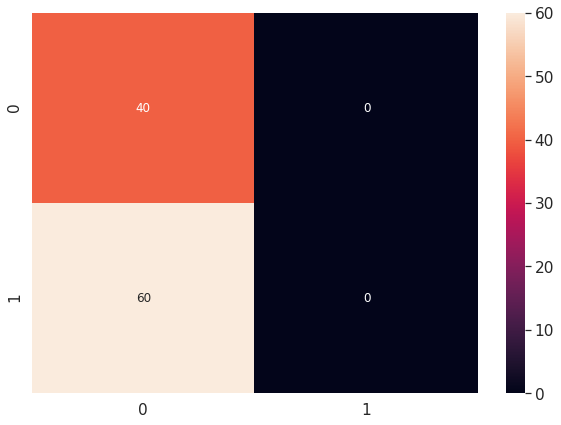

4/4 - 0s


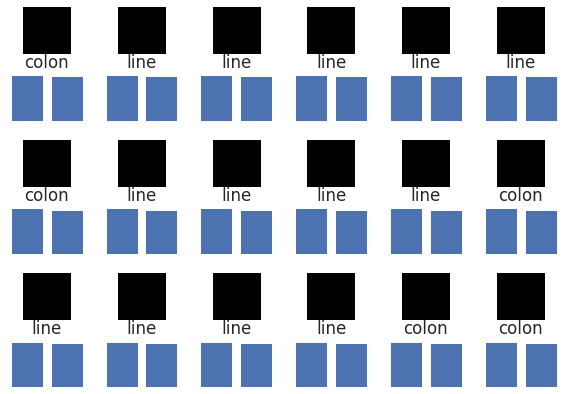

4/4 - 0s


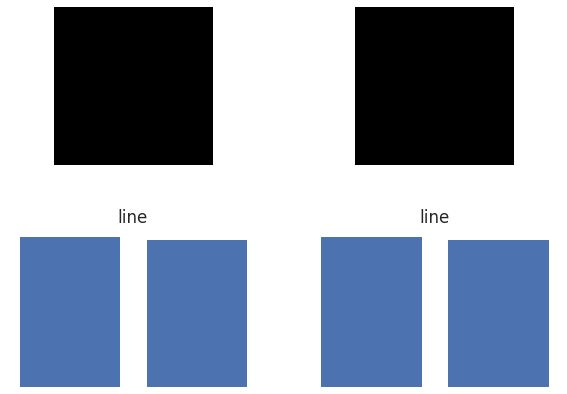

4/4 - 0s


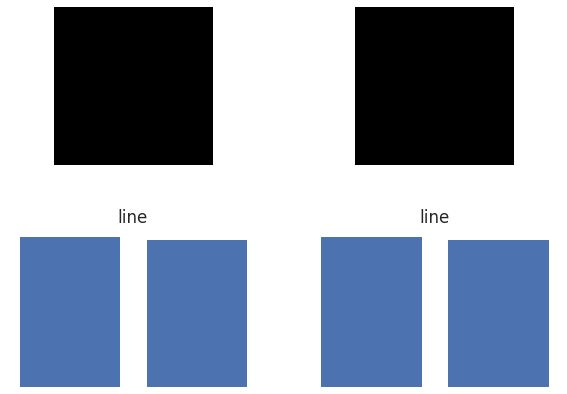

4/4 - 0s


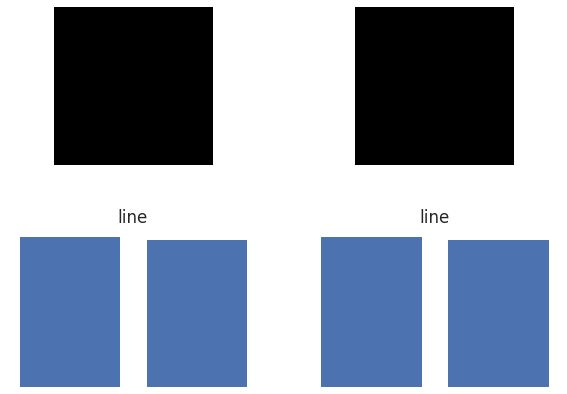

 
 
Extrapolation factor =  2.0
JPEG compression =  [8]
 
 
Figures created
Noise added
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [

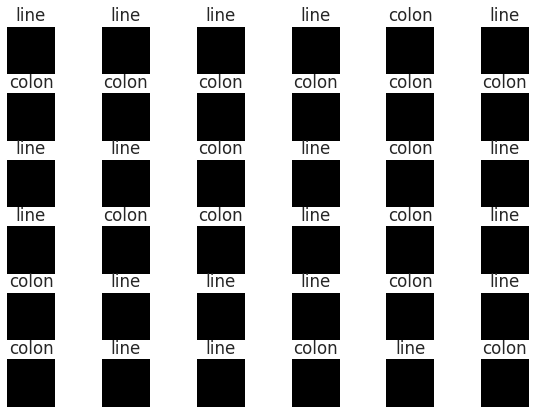

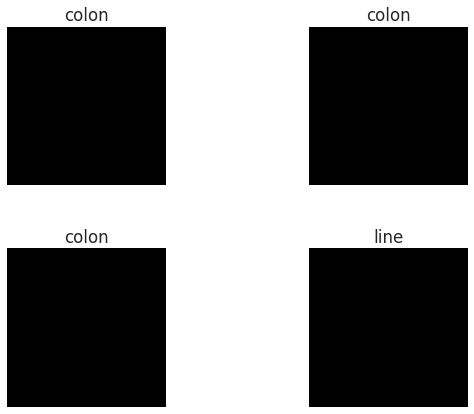

yy_train  (600, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.44000, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.44000
Accuracy Train: 49.33% , Test: 44.00% Val: 46.00% 


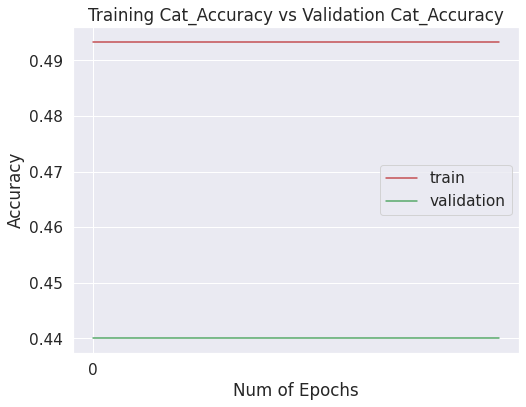

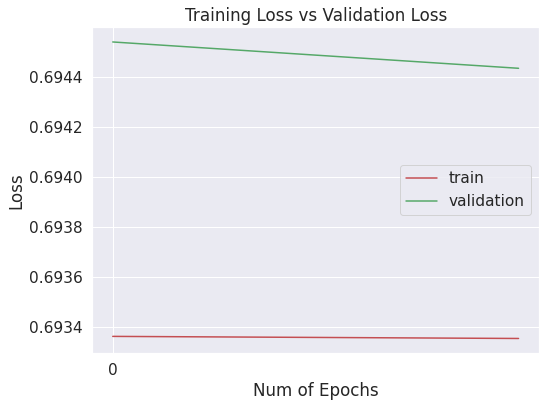

4/4 - 0s
[[46  0]
 [54  0]]


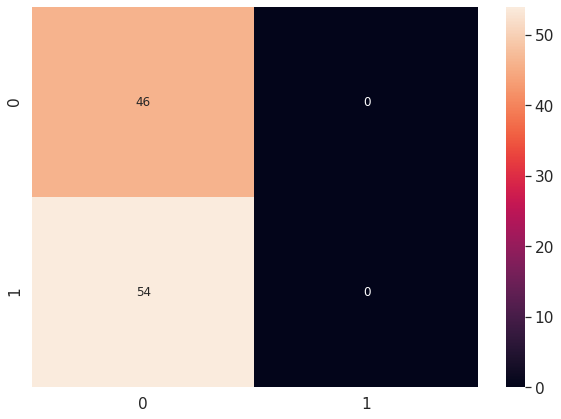

4/4 - 0s


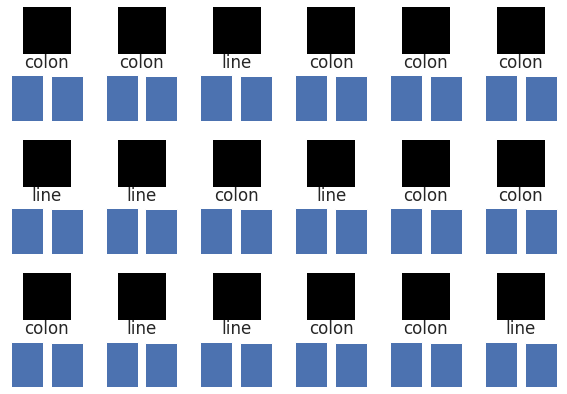

4/4 - 0s


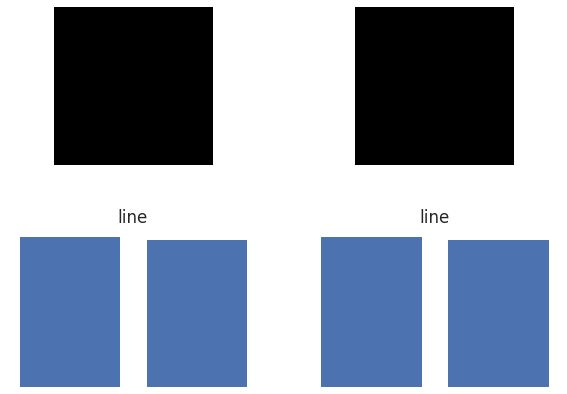

4/4 - 0s


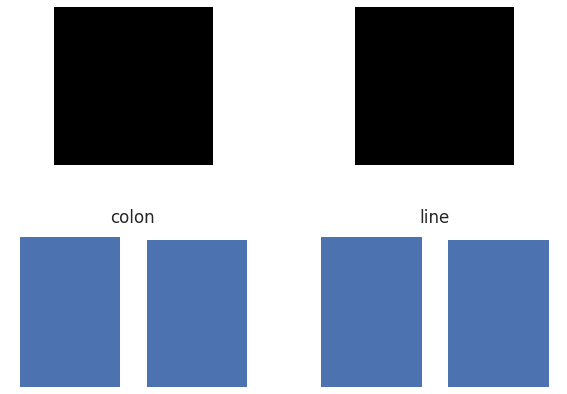

4/4 - 0s


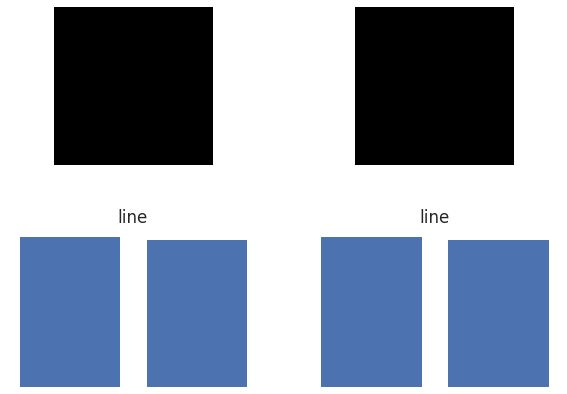

 
 
Extrapolation factor =  2.0
JPEG compression =  [16]
 
 
Figures created
Noise added
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 

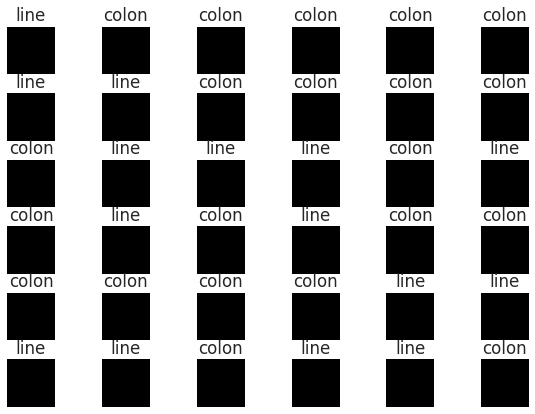

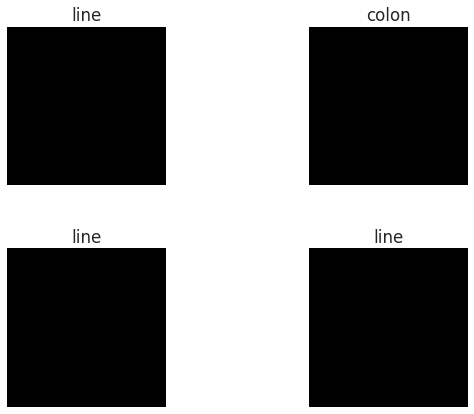

yy_train  (600, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.42000, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.42000
Accuracy Train: 51.83% , Test: 42.00% Val: 51.00% 


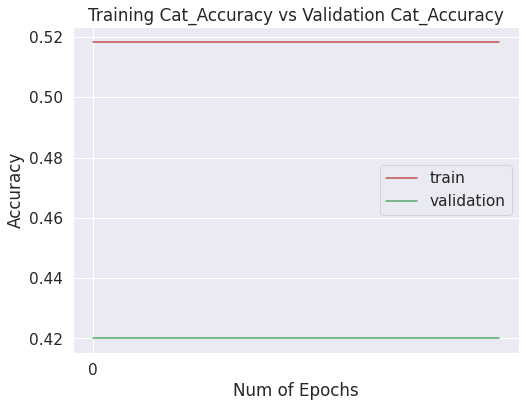

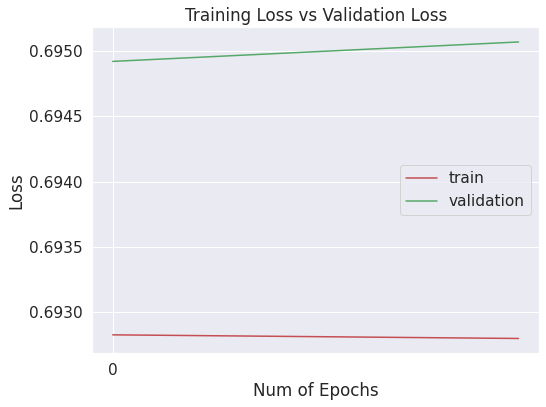

4/4 - 0s
[[51  0]
 [49  0]]


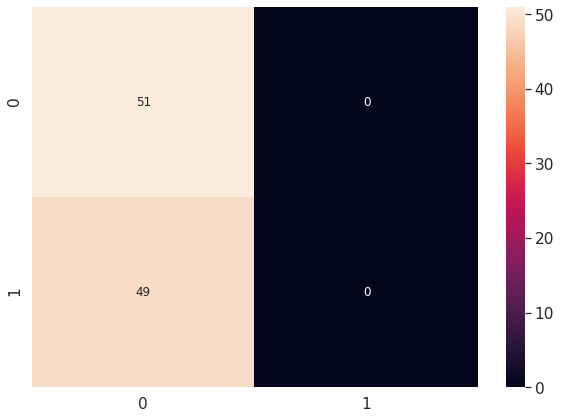

4/4 - 0s


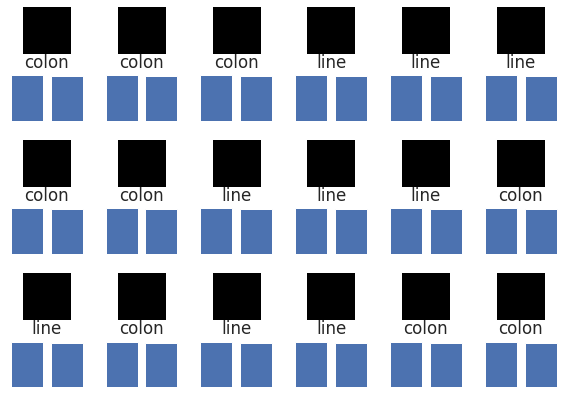

4/4 - 0s


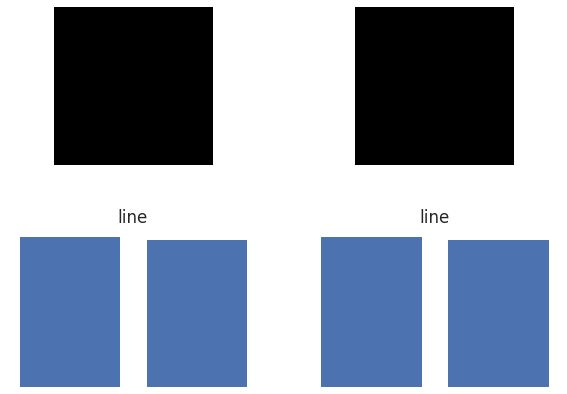

4/4 - 0s


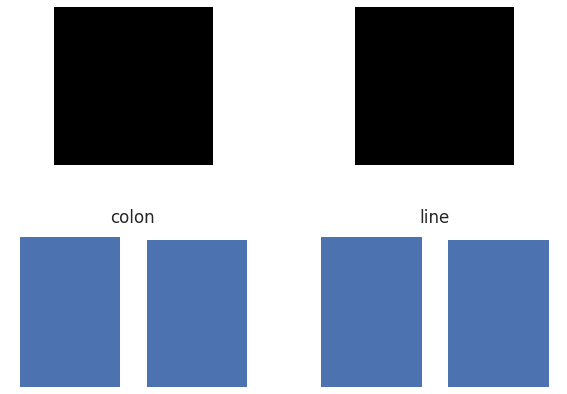

4/4 - 0s


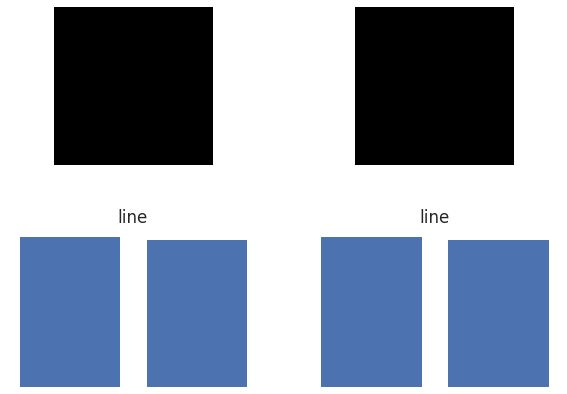

 
 
Extrapolation factor =  2.0
JPEG compression =  [32]
 
 
Figures created
Noise added
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 

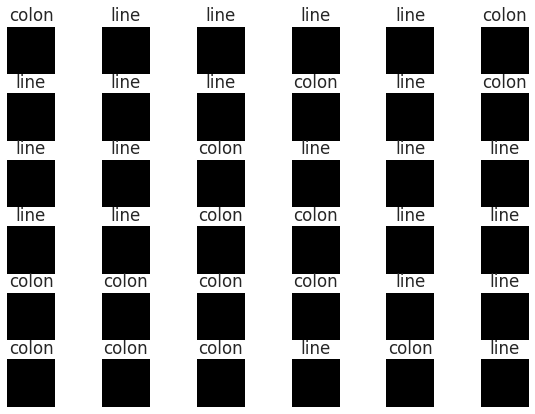

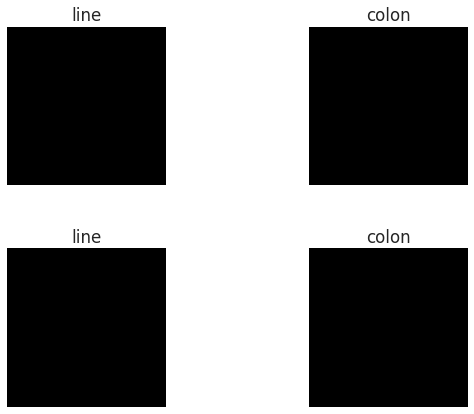

yy_train  (600, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.38000, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.38000
Accuracy Train: 54.67% , Test: 38.00% Val: 43.00% 


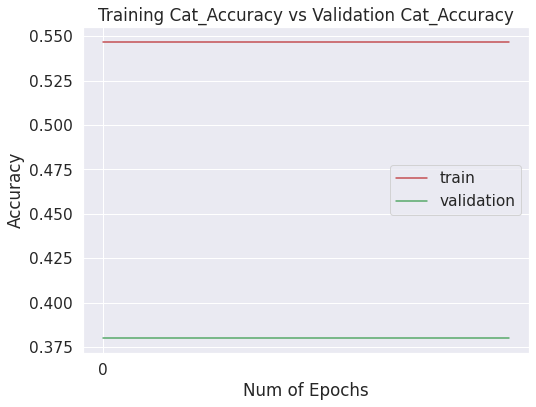

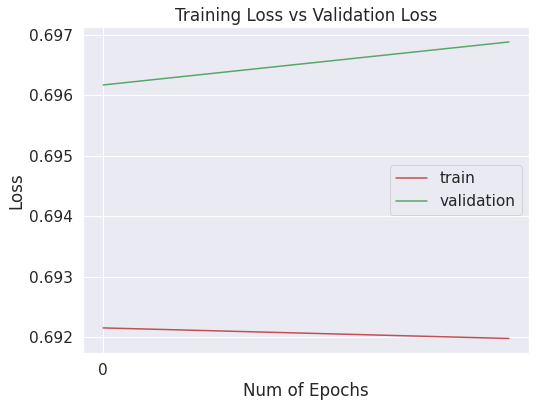

4/4 - 0s
[[43  0]
 [57  0]]


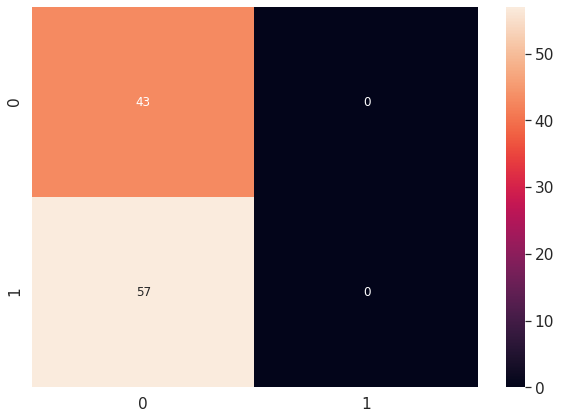

4/4 - 0s


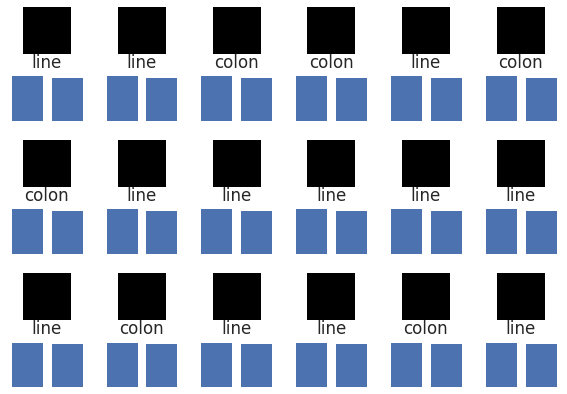

4/4 - 0s


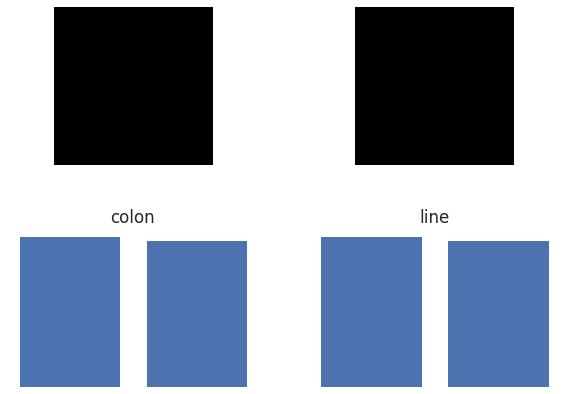

4/4 - 0s


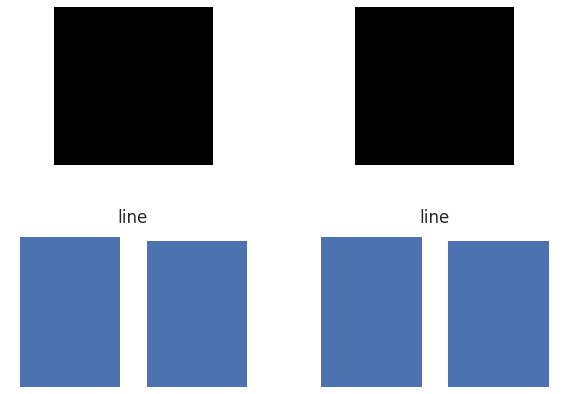

4/4 - 0s


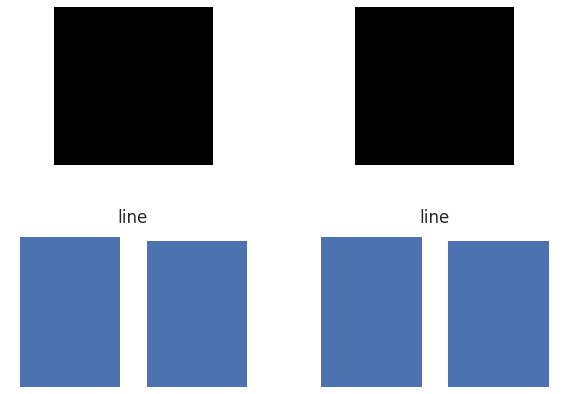

In [120]:
#acc_scores = []
#loss_scores = []

outcome = []

visual_quality = []

# Loop over extrapolations
for extrapolation_factor in extrapolation_list:

 # Loop over jpeg qualities
 if jpeg_format == 'jpeg':
   compression_list = jpeg_compression_list
 else:
  compression_list = jpeg2000_compression_list

 for jpeg_compression in compression_list:

   print(" ")
   print(" ")
   print("Extrapolation factor = ",extrapolation_factor)
   print("JPEG compression = ",jpeg_compression)
   print(" ")
   print(" ")
 
   # Generate data
   xx_train, xx_test, xx_val, yy_train, yy_test, yy_val, av_size = generate_datasets()

   #plot 100 figures (random offset)

   plot_images(6)


   plot_images(2)



   yy_train = np_utils.to_categorical(yy_train, num_classes)
   yy_test = np_utils.to_categorical(yy_test, num_classes)
   yy_val = np_utils.to_categorical(yy_val, num_classes)

   print("yy_train ",yy_train.shape)

   #Define the network
   cnn_n = base_model()
   # load the previously saved model
   try:
      cnn_n = load_model('best_model.h5')
   except:
      print("No saved model, training a new one.") 

   # patient early stopping
   es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1, patience=10)
   mc = ModelCheckpoint('best_model.h5', monitor='val_categorical_accuracy', mode='max', verbose=1, save_best_only=True)

   # fit model
   cnn = cnn_n.fit(xx_train, yy_train, batch_size=batch_size, epochs=epochs, validation_data=(xx_test,yy_test),shuffle=True, callbacks=[es, mc], verbose=0)
   # load the saved model
   saved_model = load_model('best_model.h5')


   # evaluate loaded model
   scores_train = saved_model.evaluate(xx_train, yy_train, verbose=0)
   scores_test  = saved_model.evaluate(xx_test,  yy_test,  verbose=0)
   scores_val   = saved_model.evaluate(xx_val,   yy_val,   verbose=0)
   print("Accuracy Train: %.2f%% , Test: %.2f%% Val: %.2f%% " % (scores_train[1]*100, scores_test[1]*100, scores_val[1]*100))

   # add scores
#   acc_scores.append(scores_val[1]*100)
#   loss_scores.append(scores_val[0]*100)
   outcome_row = (extrapolation_factor, jpeg_compression, av_size, scores_val[1]*100, scores_val[0]*100)
   outcome.append(outcome_row)

   #Plot training results
   plot_training_results(cnn)
   # Confussion matrix result
   draw_confussion_matrix()

   # Plot classified images
   plot_results(6)


   plot_results(2)
   plot_results(2)
   plot_results(2)




# **ZIP images**

In [121]:
# zipping images and copying to google disk commented out
#! zip images.zip images/* 
#! cp images.zip /content/drive/My\ Drive/images_jpeg_bilinear.zip

# **Draw accuracy and loss vs. jpeg quality**

[(0.5, [1], 13.53, 51.99999809265137, 69.31359767913818), (0.5, [2], 5.15, 50.999999046325684, 69.31325793266296), (0.5, [4], 2.68, 51.99999809265137, 69.30656433105469), (0.5, [8], 2.644, 40.99999964237213, 69.39346194267273), (0.5, [16], 2.648, 54.00000214576721, 69.26345825195312), (0.5, [32], 2.644, 43.00000071525574, 69.42780017852783), (1.0, [1], 13.506, 43.99999976158142, 69.42269206047058), (1.0, [2], 5.024, 56.99999928474426, 69.19151544570923), (1.0, [4], 2.7, 43.00000071525574, 69.43942308425903), (1.0, [8], 2.634, 50.999999046325684, 69.30001974105835), (1.0, [16], 2.634, 56.00000023841858, 69.20498609542847), (1.0, [32], 2.644, 52.99999713897705, 69.26290988922119), (2.0, [1], 13.546, 54.00000214576721, 69.24074292182922), (2.0, [2], 5.188, 46.99999988079071, 69.38443779945374), (2.0, [4], 2.706, 40.00000059604645, 69.54918503761292), (2.0, [8], 2.65, 46.00000083446503, 69.40953731536865), (2.0, [16], 2.64, 50.999999046325684, 69.2990243434906), (2.0, [32], 2.634, 43.00000

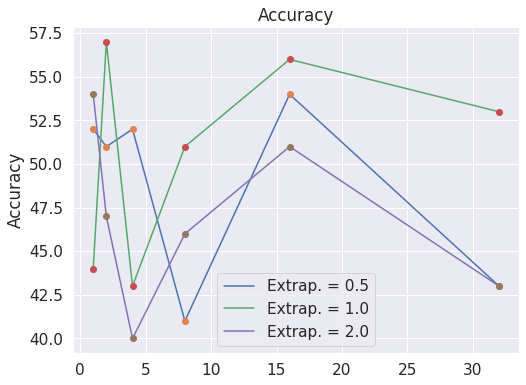

In [122]:
#plot accuracy

print(outcome)

poly=[]
compr=[]
size=[]
extrap_last = -9999
for row in range(0,len(outcome)):
   extrap = outcome[row][0]
   #print(row,outcome[row] )
   if row == 0:
     extrap_last = extrap
     poly.append(outcome[row][3])
     compr.append(outcome[row][1])
     size.append(outcome[row][2])
     print(compr, poly)
   elif extrap != extrap_last:
     line, = pyl.plot(compr, poly)
     pyl.plot(compr, poly,"o")
     print("plot ",extrap_last,compr, poly)
     label = "Extrap. = "+str(extrap_last)
     line.set_label(label)
     poly=[]
     compr=[]
     size=[]
     poly.append(outcome[row][3])
     compr.append(outcome[row][1])
     size.append(outcome[row][2])
     extrap_last = extrap
   elif row == len(outcome)-1:
     poly.append(outcome[row][3])
     compr.append(outcome[row][1]) 
     size.append(outcome[row][2]) 
     line, = pyl.plot(compr, poly)
     pyl.plot(compr, poly,"o")
     print("plot ",extrap_last,compr, poly)
     label = "Extrap. = "+str(extrap_last)
     line.set_label(label)          
   else:
     poly.append(outcome[row][3])
     compr.append(outcome[row][1])
     size.append(outcome[row][2])



pyl.legend() 

pyl.title("Accuracy")
auxText = ""
if (jpeg_format == "JPEG2000"):
   auxText == "JPEG200 compression"
elif (jpeg_format == "jpeg"):
   auxText == "jpeg quality"  
pyl.xlabel(auxText)
pyl.ylabel("Accuracy")
pyl.show()


#print("Accuracy: ", acc_scores)
#print("JPEG compression: ", compression_list)

[(0.5, [1], 13.53, 51.99999809265137, 69.31359767913818), (0.5, [2], 5.15, 50.999999046325684, 69.31325793266296), (0.5, [4], 2.68, 51.99999809265137, 69.30656433105469), (0.5, [8], 2.644, 40.99999964237213, 69.39346194267273), (0.5, [16], 2.648, 54.00000214576721, 69.26345825195312), (0.5, [32], 2.644, 43.00000071525574, 69.42780017852783), (1.0, [1], 13.506, 43.99999976158142, 69.42269206047058), (1.0, [2], 5.024, 56.99999928474426, 69.19151544570923), (1.0, [4], 2.7, 43.00000071525574, 69.43942308425903), (1.0, [8], 2.634, 50.999999046325684, 69.30001974105835), (1.0, [16], 2.634, 56.00000023841858, 69.20498609542847), (1.0, [32], 2.644, 52.99999713897705, 69.26290988922119), (2.0, [1], 13.546, 54.00000214576721, 69.24074292182922), (2.0, [2], 5.188, 46.99999988079071, 69.38443779945374), (2.0, [4], 2.706, 40.00000059604645, 69.54918503761292), (2.0, [8], 2.65, 46.00000083446503, 69.40953731536865), (2.0, [16], 2.64, 50.999999046325684, 69.2990243434906), (2.0, [32], 2.634, 43.00000

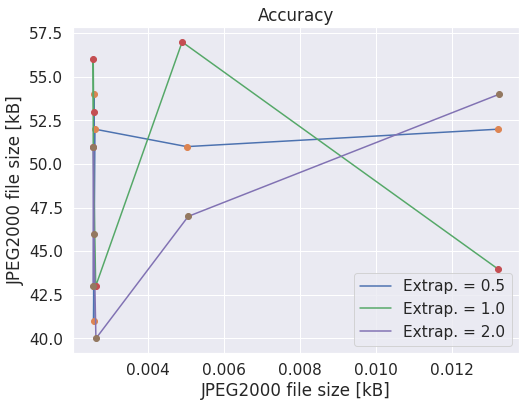

[0.013228515625, 0.00506640625, 0.002642578125, 0.002587890625, 0.002578125, 0.002572265625]
[[1], [2], [4], [8], [16], [32]]
[54.00000214576721, 46.99999988079071, 40.00000059604645, 46.00000083446503, 50.999999046325684, 43.00000071525574]


In [123]:
#plot accuracy

print(outcome)

poly=[]
compr=[]
size=[]
extrap_last = -9999
for row in range(0,len(outcome)):
   extrap = outcome[row][0]
   #print(row,outcome[row] )
   if row == 0:
     extrap_last = extrap
     poly.append(outcome[row][3])
     compr.append(outcome[row][1])
     size.append(outcome[row][2]/1024.)
     #print(size, poly)
   elif extrap != extrap_last:
     line, = pyl.plot(size, poly)
     pyl.plot(size, poly,"o")
     #print("plot ",extrap_last,size, poly)
     label = "Extrap. = "+str(extrap_last)
     line.set_label(label)
     poly=[]
     compr=[]
     size=[]
     poly.append(outcome[row][3])
     compr.append(outcome[row][1])
     size.append(outcome[row][2]/1024.)
     extrap_last = extrap
   elif row == len(outcome)-1:
     poly.append(outcome[row][3])
     compr.append(outcome[row][1]) 
     size.append(outcome[row][2]/1024.) 
     line, = pyl.plot(size, poly)
     pyl.plot(size, poly,"o")
     #print("plot ",extrap_last,size, poly)
     label = "Extrap. = "+str(extrap_last)
     line.set_label(label) 
     print(size)
     print(compr)
     print(poly)         
   else:
     poly.append(outcome[row][3])
     compr.append(outcome[row][1])
     size.append(outcome[row][2]/1024.)



pyl.legend() 

pyl.title("Accuracy")
auxText = jpeg_format+" file size [kB]"
pyl.xlabel(auxText)
pyl.ylabel(auxText)
pyl.show()

print(size)
print(compr)
print(poly)
#print("Accuracy: ", acc_scores)
#print("JPEG compression: ", compression_list)


In [124]:
#plot loss
#pyl.plot(jpeg_compression_list, loss_scores)
#pyl.plot(jpeg_compression_list, loss_scores,'o')
#pyl.title("Loss")
#pyl.xlabel("JPEG quality")
#pyl.ylabel("Loss")
#pyl.show()

# **Draw SSIM visual quality vs. jpeg quality and file size**

visual_quality  [[0.06980086211340568, 1.0, 0.00304917061263523, 0.0], [0.06866957062203995, 1.0, 0.0030709730700579836, 0.0], [0.06931729823995393, 1.0, 0.0030744914477209215, 0.0], [0.06867773826842509, 1.0, 0.0030934283257094924, 0.0], [0.0688104255160237, 1.0, 0.003052551841410429, 0.0], [0.0697633723299564, 1.0, 0.0030463862973317745, 0.0], [0.06942017811438066, 1.0, 0.0030208301953494553, 0.0], [0.06992892410673994, 1.0, 0.0030270859768284325, 0.0], [0.07002428554443273, 1.0, 0.0030224342438416323, 0.0], [0.06953327065952562, 1.0, 0.003030187498466431, 0.0], [0.06923527694433598, 1.0, 0.003042191408705231, 0.0], [0.06932388616205538, 1.0, 0.0030537099268477764, 0.0], [0.0699772269045998, 1.0, 0.0030250380694295505, 0.0], [0.0683221898441572, 1.0, 0.0030650995425308527, 0.0], [0.06950885221821611, 1.0, 0.003096359706236195, 0.0], [0.06621277369340045, 1.0, 0.00309676780621795, 0.0], [0.06832739323425951, 1.0, 0.0030826574316016155, 0.0], [0.06881059876149652, 1.0, 0.00303443157147

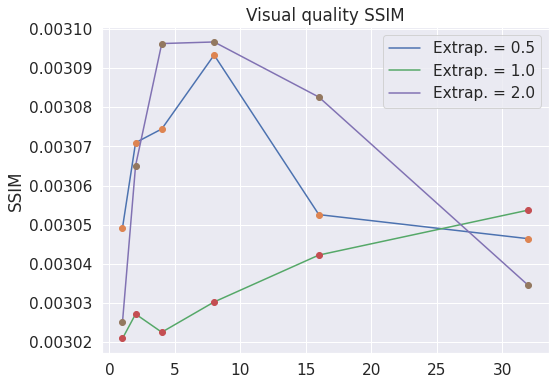

In [125]:
#plot SSIM

print("visual_quality ",visual_quality)
print(len(outcome), len(visual_quality))

poly=[]
compr=[]
size=[]
extrap_last = -9999
for row in range(0,len(outcome)):
   extrap = outcome[row][0]
   #print(row,outcome[row] )
   if row == 0:
     extrap_last = extrap
     poly.append(visual_quality[row][2])
     compr.append(outcome[row][1])
     size.append(outcome[row][2])
     print(compr, poly)
   elif extrap != extrap_last:
     line, = pyl.plot(compr, poly)
     pyl.plot(compr, poly,"o")
     print("plot ",extrap_last,compr, poly)
     label = "Extrap. = "+str(extrap_last)
     line.set_label(label)
     poly=[]
     compr=[]
     size=[]
     poly.append(visual_quality[row][2])
     compr.append(outcome[row][1])
     size.append(outcome[row][2])
     extrap_last = extrap
   elif row == len(outcome)-1:
     poly.append(visual_quality[row][2])
     compr.append(outcome[row][1]) 
     size.append(outcome[row][2]) 
     line, = pyl.plot(compr, poly)
     pyl.plot(compr, poly,"o")
     print("SSIM ",extrap_last,compr, poly)
     label = "Extrap. = "+str(extrap_last)
     line.set_label(label)          
   else:
     poly.append(visual_quality[row][2])
     compr.append(outcome[row][1])
     size.append(outcome[row][2])



pyl.legend() 

pyl.title("Visual quality SSIM")
auxText = ""
if (jpeg_format == "JPEG2000"):
   auxText == "JPEG200 compression"
elif (jpeg_format == "jpeg"):
   auxText == "jpeg quality"  
pyl.xlabel(auxText)
pyl.ylabel("SSIM")
pyl.show()


#print("Accuracy: ", acc_scores)
#print("JPEG compression: ", compression_list)


[(0.5, [1], 13.53, 51.99999809265137, 69.31359767913818), (0.5, [2], 5.15, 50.999999046325684, 69.31325793266296), (0.5, [4], 2.68, 51.99999809265137, 69.30656433105469), (0.5, [8], 2.644, 40.99999964237213, 69.39346194267273), (0.5, [16], 2.648, 54.00000214576721, 69.26345825195312), (0.5, [32], 2.644, 43.00000071525574, 69.42780017852783), (1.0, [1], 13.506, 43.99999976158142, 69.42269206047058), (1.0, [2], 5.024, 56.99999928474426, 69.19151544570923), (1.0, [4], 2.7, 43.00000071525574, 69.43942308425903), (1.0, [8], 2.634, 50.999999046325684, 69.30001974105835), (1.0, [16], 2.634, 56.00000023841858, 69.20498609542847), (1.0, [32], 2.644, 52.99999713897705, 69.26290988922119), (2.0, [1], 13.546, 54.00000214576721, 69.24074292182922), (2.0, [2], 5.188, 46.99999988079071, 69.38443779945374), (2.0, [4], 2.706, 40.00000059604645, 69.54918503761292), (2.0, [8], 2.65, 46.00000083446503, 69.40953731536865), (2.0, [16], 2.64, 50.999999046325684, 69.2990243434906), (2.0, [32], 2.634, 43.00000

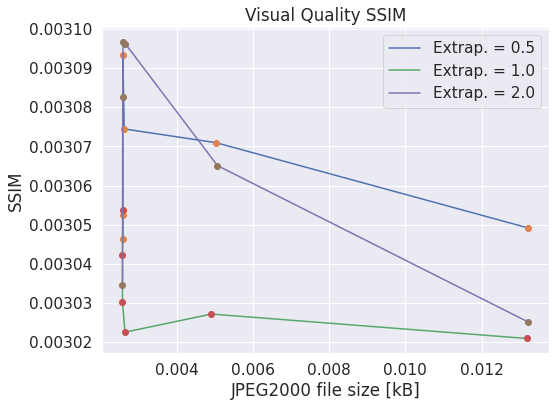

[0.013228515625, 0.00506640625, 0.002642578125, 0.002587890625, 0.002578125, 0.002572265625]
[[1], [2], [4], [8], [16], [32]]
[0.0030250380694295505, 0.0030650995425308527, 0.003096359706236195, 0.00309676780621795, 0.0030826574316016155, 0.0030344315714794564]


In [126]:
#plot SSIM

print(outcome)

poly=[]
compr=[]
size=[]
extrap_last = -9999
for row in range(0,len(outcome)):
   extrap = outcome[row][0]
   #print(row,outcome[row] )
   if row == 0:
     extrap_last = extrap
     poly.append(visual_quality[row][2])
     compr.append(outcome[row][1])
     size.append(outcome[row][2]/1024.)
     #print(size, poly)
   elif extrap != extrap_last:
     line, = pyl.plot(size, poly)
     pyl.plot(size, poly,"o")
     #print("plot ",extrap_last,size, poly)
     label = "Extrap. = "+str(extrap_last)
     line.set_label(label)
     poly=[]
     compr=[]
     size=[]
     poly.append(visual_quality[row][2])
     compr.append(outcome[row][1])
     size.append(outcome[row][2]/1024.)
     extrap_last = extrap
   elif row == len(outcome)-1:
     poly.append(visual_quality[row][2])
     compr.append(outcome[row][1]) 
     size.append(outcome[row][2]/1024.) 
     line, = pyl.plot(size, poly)
     pyl.plot(size, poly,"o")
     #print("plot ",extrap_last,size, poly)
     label = "Extrap. = "+str(extrap_last)
     line.set_label(label) 
     print(size)
     print(compr)
     print(poly)         
   else:
     poly.append(visual_quality[row][2])
     compr.append(outcome[row][1])
     size.append(outcome[row][2]/1024.)



pyl.legend() 

pyl.title("Visual Quality SSIM")
auxText = jpeg_format+" file size [kB]"
pyl.xlabel(auxText)
pyl.ylabel('SSIM')
pyl.show()

print(size)
print(compr)
print(poly)
#print("Accuracy: ", acc_scores)
#print("JPEG compression: ", compression_list)


# **Draw Quality Index vs. jpeg quality and file size**

visual_quality  [[0.06980086211340568, 1.0, 0.00304917061263523, 0.0], [0.06866957062203995, 1.0, 0.0030709730700579836, 0.0], [0.06931729823995393, 1.0, 0.0030744914477209215, 0.0], [0.06867773826842509, 1.0, 0.0030934283257094924, 0.0], [0.0688104255160237, 1.0, 0.003052551841410429, 0.0], [0.0697633723299564, 1.0, 0.0030463862973317745, 0.0], [0.06942017811438066, 1.0, 0.0030208301953494553, 0.0], [0.06992892410673994, 1.0, 0.0030270859768284325, 0.0], [0.07002428554443273, 1.0, 0.0030224342438416323, 0.0], [0.06953327065952562, 1.0, 0.003030187498466431, 0.0], [0.06923527694433598, 1.0, 0.003042191408705231, 0.0], [0.06932388616205538, 1.0, 0.0030537099268477764, 0.0], [0.0699772269045998, 1.0, 0.0030250380694295505, 0.0], [0.0683221898441572, 1.0, 0.0030650995425308527, 0.0], [0.06950885221821611, 1.0, 0.003096359706236195, 0.0], [0.06621277369340045, 1.0, 0.00309676780621795, 0.0], [0.06832739323425951, 1.0, 0.0030826574316016155, 0.0], [0.06881059876149652, 1.0, 0.00303443157147

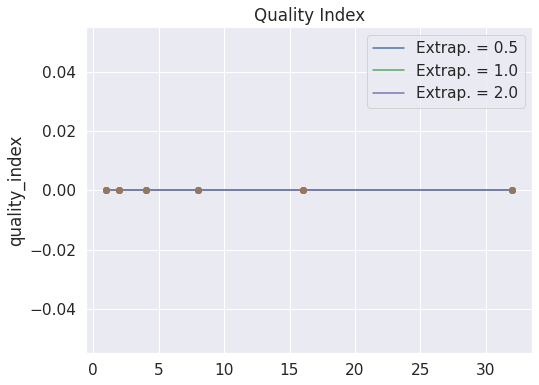

In [127]:
#plot Quality Index

print("visual_quality ",visual_quality)
print(len(outcome), len(visual_quality))

poly=[]
compr=[]
size=[]
extrap_last = -9999
for row in range(0,len(outcome)):
   extrap = outcome[row][0]
   #print(row,outcome[row] )
   if row == 0:
     extrap_last = extrap
     poly.append(visual_quality[row][3])
     compr.append(outcome[row][1])
     size.append(outcome[row][2])
     print(compr, poly)
   elif extrap != extrap_last:
     line, = pyl.plot(compr, poly)
     pyl.plot(compr, poly,"o")
     print("plot ",extrap_last,compr, poly)
     label = "Extrap. = "+str(extrap_last)
     line.set_label(label)
     poly=[]
     compr=[]
     size=[]
     poly.append(visual_quality[row][3])
     compr.append(outcome[row][1])
     size.append(outcome[row][2])
     extrap_last = extrap
   elif row == len(outcome)-1:
     poly.append(visual_quality[row][3])
     compr.append(outcome[row][1]) 
     size.append(outcome[row][2]) 
     line, = pyl.plot(compr, poly)
     pyl.plot(compr, poly,"o")
     print("Quality Index ",extrap_last,compr, poly)
     label = "Extrap. = "+str(extrap_last)
     line.set_label(label)          
   else:
     poly.append(visual_quality[row][3])
     compr.append(outcome[row][1])
     size.append(outcome[row][2])



pyl.legend() 

pyl.title("Quality Index")
auxText = ""
if (jpeg_format == "JPEG2000"):
   auxText == "JPEG200 compression"
elif (jpeg_format == "jpeg"):
   auxText == "jpeg quality"  
pyl.xlabel(auxText)
pyl.ylabel("quality_index")
pyl.show()


#print("Accuracy: ", acc_scores)
#print("JPEG compression: ", compression_list)


[(0.5, [1], 13.53, 51.99999809265137, 69.31359767913818), (0.5, [2], 5.15, 50.999999046325684, 69.31325793266296), (0.5, [4], 2.68, 51.99999809265137, 69.30656433105469), (0.5, [8], 2.644, 40.99999964237213, 69.39346194267273), (0.5, [16], 2.648, 54.00000214576721, 69.26345825195312), (0.5, [32], 2.644, 43.00000071525574, 69.42780017852783), (1.0, [1], 13.506, 43.99999976158142, 69.42269206047058), (1.0, [2], 5.024, 56.99999928474426, 69.19151544570923), (1.0, [4], 2.7, 43.00000071525574, 69.43942308425903), (1.0, [8], 2.634, 50.999999046325684, 69.30001974105835), (1.0, [16], 2.634, 56.00000023841858, 69.20498609542847), (1.0, [32], 2.644, 52.99999713897705, 69.26290988922119), (2.0, [1], 13.546, 54.00000214576721, 69.24074292182922), (2.0, [2], 5.188, 46.99999988079071, 69.38443779945374), (2.0, [4], 2.706, 40.00000059604645, 69.54918503761292), (2.0, [8], 2.65, 46.00000083446503, 69.40953731536865), (2.0, [16], 2.64, 50.999999046325684, 69.2990243434906), (2.0, [32], 2.634, 43.00000

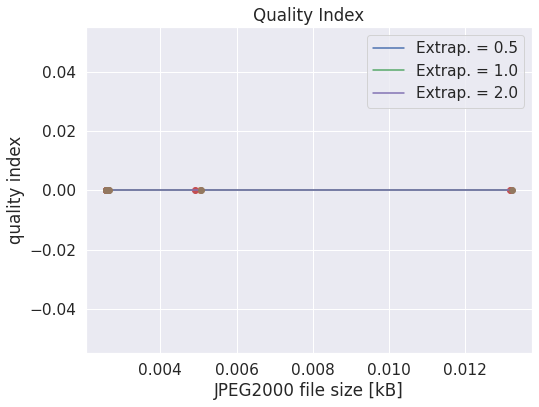

[0.013228515625, 0.00506640625, 0.002642578125, 0.002587890625, 0.002578125, 0.002572265625]
[[1], [2], [4], [8], [16], [32]]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [128]:
#plot Quality Index

print(outcome)

poly=[]
compr=[]
size=[]
extrap_last = -9999
for row in range(0,len(outcome)):
   extrap = outcome[row][0]
   #print(row,outcome[row] )
   if row == 0:
     extrap_last = extrap
     poly.append(visual_quality[row][3])
     compr.append(outcome[row][1])
     size.append(outcome[row][2]/1024.)
     #print(size, poly)
   elif extrap != extrap_last:
     line, = pyl.plot(size, poly)
     pyl.plot(size, poly,"o")
     #print("plot ",extrap_last,size, poly)
     label = "Extrap. = "+str(extrap_last)
     line.set_label(label)
     poly=[]
     compr=[]
     size=[]
     poly.append(visual_quality[row][3])
     compr.append(outcome[row][1])
     size.append(outcome[row][2]/1024.)
     extrap_last = extrap
   elif row == len(outcome)-1:
     poly.append(visual_quality[row][3])
     compr.append(outcome[row][1]) 
     size.append(outcome[row][2]/1024.) 
     line, = pyl.plot(size, poly)
     pyl.plot(size, poly,"o")
     #print("plot ",extrap_last,size, poly)
     label = "Extrap. = "+str(extrap_last)
     line.set_label(label) 
     print(size)
     print(compr)
     print(poly)         
   else:
     poly.append(visual_quality[row][3])
     compr.append(outcome[row][1])
     size.append(outcome[row][2]/1024.)



pyl.legend() 

pyl.title("Quality Index")
auxText = jpeg_format+" file size [kB]"
pyl.xlabel(auxText)
pyl.ylabel('quality index')
pyl.show()

print(size)
print(compr)
print(poly)
#print("Accuracy: ", acc_scores)
#print("JPEG compression: ", compression_list)


In [129]:
# zip results
! zip -r out_images.zip images

  adding: images/ (stored 0%)
  adding: images/image_extr_2.0_jpg2000_[8]_1.jp2 (deflated 21%)
  adding: images/image_extr_0.5_jpg2000_[2]_1.jp2 (deflated 8%)
  adding: images/image_extr_2.0_jpg2000_[16]_0.jp2 (deflated 21%)
  adding: images/image_extr_1.0_jpg2000_[32]_1.jp2 (deflated 21%)
  adding: images/image_extr_1.0_jpg2000_[8]_2.jp2 (deflated 21%)
  adding: images/image_extr_2.0_jpg2000_[8]_4.jp2 (deflated 21%)
  adding: images/image_extr_0.5_jpg2000_[32]_1.jp2 (deflated 21%)
  adding: images/image_extr_2.0_jpg2000_[2]_4.jp2 (deflated 9%)
  adding: images/image_extr_1.0_jpg2000_[4]_3.jp2 (deflated 20%)
  adding: images/image_extr_0.5_jpg2000_[2]_4.jp2 (deflated 8%)
  adding: images/image_extr_2.0_jpg2000_[16]_1.jp2 (deflated 21%)
  adding: images/image_extr_2.0_jpg2000_[2]_2.jp2 (deflated 8%)
  adding: images/image_extr_2.0_jpg2000_[32]_0.jp2 (deflated 21%)
  adding: images/image_extr_1.0_jpg2000_[1]_3.jp2 (stored 0%)
  adding: images/image_extr_2.0_jpg2000_[32]_2.jp2 (deflated 2